In [1]:
import lucem_illud #Special module written for this class

import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm #Still for graphics
import matplotlib.colors # For nice colours
import wordcloud
import numpy as np
import scipy
import glob
import seaborn as sns
import sklearn.manifold
import itertools
import json
import ast
import urllib.parse
from bs4 import BeautifulSoup as bs
import spacy #comp-linguistics
import graphviz #displays the graphs
import gensim#For topic modeling

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#To process text data
import re
import time
import string
import statsmodels.formula.api as smf
from gensim import corpora, models
from collections import Counter
from datetime import datetime
from langdetect import detect
from textblob import Word
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

/Users/gaomingtao/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Load Dataset

In [2]:
# Load Dataset
brand = "Puma"
reddit = pd.read_csv("Data/Reddit/{}.csv".format(brand))
twitter = pd.read_csv("Data/Twitter/{}.csv".format(brand))
ins = pd.read_csv("Data/Instagram/{}.csv".format(brand))
youtube = pd.read_csv("Data/YouTube/{}.csv".format(brand))

In [3]:
#Combine the title and body of Reddit posts
reddit['body'].replace(np.nan, "", inplace=True)
reddit['text'] = reddit['title'] + reddit['body']
twitter['text'] = twitter['text'].str.replace('http\S+|www.\S+', '', case=False)
ins.rename(columns={'caption': 'text'}, inplace=True)
youtube['text'] = youtube['title'] + youtube['captions']

In [4]:
#Drop nan and duplicate text
def drop_na_dup(df):
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)
    df.drop_duplicates(inplace=True)
    df.dropna(subset = ["text"], inplace=True)
    
drop_na_dup(reddit)
drop_na_dup(twitter)
drop_na_dup(ins)
drop_na_dup(youtube)

In [5]:
pd.DataFrame({'data': ['Reddit', 'Twitter', 'Instagram', 'YouTube'],
              'shape': [reddit.shape, twitter.shape, ins.shape, youtube.shape,]})

,data,shape
0,Reddit,"(1535, 8)"
1,Twitter,"(5360, 9)"
2,Instagram,"(3063, 10)"
3,YouTube,"(303, 13)"


## Counting Words & Phrases

#### Tokenize

In [6]:
def tokenize(df, size=2400):
    df = df[:size]
    df['tokenized_text'] = df['text'].apply(lambda x: lucem_illud.word_tokenize(x))
    df['word_counts'] = df['tokenized_text'].apply(lambda x: len(x))
    return df
    
reddit = tokenize(reddit)
twitter = tokenize(twitter)
ins = tokenize(ins)
youtube = tokenize(youtube)

#### Words Count

In [7]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

def wordCounter(df, limit=20):
    tokens = []
    for token in df['tokenized_text']:
        tokens += token

    wordCounts = {}
    for word in df['tokenized_text'].sum():
        wLower = word.lower()
        if word not in stopwords:
            if word in wordCounts:
                wordCounts[word] += 1
            else:
                wordCounts[word] = 1
    
    wordFreq_lst = []
    for word, count in sorted(wordCounts.items(), key = lambda x : x[1], reverse = True)[:limit]:
        wordFreq_lst.append(word)
    
    wordCounts_df = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        wordCounts_df['word'].append(w)
        wordCounts_df['count'].append(c)
    wordCounts_df = pd.DataFrame(wordCounts_df) 
    wordCounts_df.sort_values('count', ascending=False, inplace=True)
    return tokens, wordFreq_lst, wordCounts_df

In [8]:
token_rdt, wordFreq_rdt, wordsCount_rdt = wordCounter(reddit)
token_twt, wordFreq_twt, wordsCount_twt = wordCounter(twitter)
token_ins, wordFreq_ins, wordsCount_ins = wordCounter(ins)
token_ytb, wordFreq_ytb, wordsCount_ytb = wordCounter(youtube)

In [9]:
def normalize(df, words_freq, limit=5):
    df['normalized_tokens'] = df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, extra_stop=words_freq[:limit]))
    return df

reddit = normalize(reddit, wordFreq_rdt)
twitter = normalize(twitter, ['rt'] + wordFreq_twt, 8)
ins = normalize(ins, wordFreq_ins)
youtube = normalize(youtube, wordFreq_ytb, 10)

In [10]:
def detectLanguage(df, col):
    for index, row in df[col].iteritems():
        try:
            lang = detect(row)
            df.loc[index, 'language'] = lang
        except:
            df.loc[index, 'language'] = "not detectable"
    return df

In [11]:
reddit = detectLanguage(reddit,'text')
reddit = reddit[reddit['language'] == 'en']
twitter = detectLanguage(twitter,'text')
twitter = twitter[twitter['language'] == 'en']
ins = detectLanguage(ins,'text')
ins = ins[ins['language'] == 'en']

In [12]:
reddit.head()

,title,upvotes,upvote_ratio,url,num_commns,created,body,text,tokenized_text,word_counts,normalized_tokens,language
0,"Puma experts, looking for photos of",3,0.81,https://www.reddit.com/r/PUMA/comments/naz1gv/...,0,2021-05-12 16:49:56,"F-skate shoes. Made in 2004, I think so. That ...","Puma experts, looking for photos ofF-skate sho...","[Puma, experts, looking, for, photos, ofF, ska...",37,"[puma, experts, looking, photos, skate, think,...",en
1,J COLE SLAM COVER - DREAMER 2 MID US PREMEIRE....,15,0.94,https://www.reddit.com/gallery/na4rfg,0,2021-05-11 15:03:52,,J COLE SLAM COVER - DREAMER 2 MID US PREMEIRE....,"[J, COLE, SLAM, COVER, DREAMER, 2, MID, US, PR...",14,"[j, cole, slam, cover, dreamer, mid, premeire,...",en
2,Any news on more Cryptozoology pumas?,2,1.00,https://www.reddit.com/r/PUMA/comments/na3kvk/...,0,2021-05-11 14:15:04,I have the Puma mothman series RS-X shoes and ...,Any news on more Cryptozoology pumas?I have th...,"[Any, news, on, more, Cryptozoology, pumas?I, ...",66,"[news, cryptozoology, pumas?i, puma, mothman, ...",en
3,Best PUMA’s for Volleyball?,2,1.00,https://www.reddit.com/r/PUMA/comments/na0bhv/...,4,2021-05-11 11:59:04,getting back into volleyball in preparation fo...,Best PUMA’s for Volleyball?getting back into v...,"[Best, PUMA, ’s, for, Volleyball?getting, back...",67,"[best, puma, volleyball?getting, volleyball, p...",en
4,"Dua Lipa in RS-X3, what’s the name of this col...",3,1.00,https://i.redd.it/zsba80m0fby61.jpg,0,2021-05-10 11:55:12,,"Dua Lipa in RS-X3, what’s the name of this col...","[Dua, Lipa, in, RS, X3, what, ’s, the, name, o...",12,"[dua, lipa, rs, x3, colorway]",en


In [13]:
twitter.head()

,time,text,user_name,user_location,retweet_cnt,favorite_cnt,hashtags,user_mentions,is_retweet,tokenized_text,word_counts,normalized_tokens,language
0,2021-05-14 13:08:33,RT @KidSuper: The KidSuper x Puma sandals drop...,taylors_titter,The kitchen,9,0,[],['KidSuper'],True,"[RT, @KidSuper, The, KidSuper, x, Puma, sandal...",11,"[@kidsuper, kidsuper, x, sandals, dropping, we...",en
1,2021-05-14 13:08:16,"@GreatWhiteNueve Thing is, it’s a sponsorship ...",IAmAllfather,Mouth of the River,0,2,[],['GreatWhiteNueve'],False,"[@GreatWhiteNueve, Thing, is, it, ’s, a, spons...",21,"[@greatwhitenueve, thing, sponsorship, jordan,...",en
2,2021-05-14 13:08:09,Just Arrived! Case IH Puma 200 Powershift C/W ...,startintractors,"Twycross, England",0,0,[],[],False,"[Just, Arrived, Case, IH, Puma, 200, Powershif...",18,"[arrived, case, ih, powershift, c, w, linkage,...",en
3,2021-05-14 13:07:50,@nicolasknoxxx Only real ones know about the P...,emoxvx,"Porto, Portugal",0,1,[],['nicolasknoxxx'],False,"[@nicolasknoxxx, Only, real, ones, know, about...",9,"[@nicolasknoxxx, real, ones, hardchorus]",en
4,2021-05-14 13:07:27,@OUchenna11 @EskSamuel You actually did me a f...,Puma_guy77,"Warsaw, Poland 🇵🇱🇵🇱",0,0,[],"['OUchenna11', 'EskSamuel', 'EskSamuel']",False,"[@OUchenna11, @EskSamuel, You, actually, did, ...",25,"[@ouchenna11, @esksamuel, actually, favor, cos...",en


In [14]:
ins.head()

,timestamp,text,user,full_name,likes,image_url,dimensions,location,country,tagged_account,tokenized_text,word_counts,normalized_tokens,language
0,2021-05-13 13:00:46,The @cobragolf @pumagolf boys are out here. @k...,coach_rusty,Ryan Rustand,2508,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,"{'height': 1150, 'width': 1080}","{'street_address': '2301 Alton Rd', 'zip_code'...",US,"['cobragolf', 'pumagolf', 'kyleberkshire']","[The, @cobragolf, @pumagolf, boys, are, out, h...",10,"[@cobragolf, @pumagolf, boys, @kyleberkshire, ...",en
1,2021-05-13 06:45:28,Since so many were interested in my post from ...,just.in.puma,Justin Oliver,146,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,"{'height': 1080, 'width': 1080}",NaN,NaN,"['puma', 'nicekicks', 'pumasportstyle', 'sneak...","[Since, so, many, were, interested, in, my, po...",52,"[interested, post, mother, day, pair, pack, x,...",en
2,2021-05-12 20:04:17,"If you are interested in my products, please a...",gentlemanface2,gentlemanface2,144,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,"{'height': 1080, 'width': 1080}","{'street_address': '', 'zip_code': '', 'city_n...",NaN,[],"[If, you, are, interested, in, my, products, p...",30,"[interested, products, add, contact, whatsapp+...",en
14,2021-05-13 14:10:00,Still far away from my goals but on the right ...,_chezvalerie_,Vαʅéɾιҽ,38,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,"{'height': 1285, 'width': 1080}",NaN,NaN,[],"[Still, far, away, from, my, goals, but, on, t...",25,"[far, away, goals, right, direction, think, 😅,...",en
15,2021-05-13 14:09:45,Selfing😉 with my bra @maher_lasquale ✨👥🤳 #dz #...,aymen.zaidi77,AyMen🌹✨,63,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,"{'height': 1350, 'width': 1080}",NaN,NaN,[],"[Selfing, 😉, with, my, bra, @maher_lasquale, ✨...",24,"[selfing, 😉, bra, @maher_lasquale, ✨, 👥, 🤳, dz...",en


In [15]:
youtube.head()

,captions,categoryId,channelId,channelTitle,commentCount,dislikeCount,favoriteCount,likeCount,tags,title,videoId,viewCount,text,tokenized_text,word_counts,normalized_tokens
26,hi it's kerry i have a passion forcollecting a...,22,UCakv392OANtWgdG76yTE3vw,CaroSeria,461,44,0,2339,"['ford puma', 'puma st', 'test forda', 'ford t...","Ford Puma ST, czyli jak przełknąć żabę (TEST P...",F-ioi73eNdo,83414,"Ford Puma ST, czyli jak przełknąć żabę (TEST P...","[Ford, Puma, ST, czyli, jak, przełknąć, żabę, ...",549,"[ford, st, czyli, jak, przełknąć, żabę, test, ..."
28,hi it's kerry i have a passion forcollecting a...,17,UCVtWA8MwZHC0slEpIeUOfdw,David Rau,202,12,0,803,"['puam future', 'puma future z', 'puma future ...",Puma Future Z Playtest - New boots for Neymar!,vIaEW46Zi8U,31115,Puma Future Z Playtest - New boots for Neymar!...,"[Puma, Future, Z, Playtest, New, boots, for, N...",546,"[future, z, playtest, new, boots, neymar!hi, k..."
29,hi it's kerry i have a passion forcollecting a...,24,UCvn-HVrAGYEKsVx6gW3MeNQ,VH1,403,108,0,4150,"['VH1', 'reality tv', 'reality show', 'black i...","Ceaser Blows Up, Bae’s Wedding Nightmare, Puma...",sf0r1Ang5FY,180609,"Ceaser Blows Up, Bae’s Wedding Nightmare, Puma...","[Ceaser, Blows, Up, Bae, ’s, Wedding, Nightmar...",555,"[ceaser, blows, bae, wedding, nightmare, retur..."
30,hi it's kerry i have a passion forcollecting a...,15,UCvph04Sh9CFKAw-gA6y-brQ,I_am_puma,2384,158,0,24665,"['пума дома', 'пума', 'месси', 'пума в доме', ...",Самое милое видео пумы Месси!,4FlpckCpzXI,364210,Самое милое видео пумы Месси!hi it's kerry i h...,"[Самое, милое, видео, пумы, Месси!hi, it, 's, ...",543,"[самое, милое, видео, пумы, месси!hi, kerry, p..."
31,hi it's kerry i have a passion forcollecting a...,22,UC-4ElZEj-vLnFAdVvdRjkqQ,流行案內所 POPtable Show,46,14,0,715,"['Maison Kitsuné', 'Puma', '193', '流行案內所', 'er...",日法狐狸Maison Kitsuné與Puma美洲獅 ft. @Denis Kwok 193...,xVlEomattYM,23169,日法狐狸Maison Kitsuné與Puma美洲獅 ft. @Denis Kwok 193...,"[日法狐狸Maison, Kitsuné與Puma美洲獅, ft, @Denis, Kwok...",550,"[日法狐狸maison, kitsuné與puma美洲獅, ft, @denis, kwok..."


In [12]:
df_lst = [reddit, twitter, ins, youtube]
title_lst = ["Reddit", "Twitter", "Instagram", "YouTube"]

#### Frequently Used Hashtags

In [17]:
# This function is used to extract hashtags from the caption
def get_hashtags(text, order=False):
    tags = list([item.strip("#.,-\"\'&*^!") for item in text.split() if (item.startswith("#") and len(item) < 256)])
    return sorted(tags) if order else tags

# To display the most frequent hashtags appeared together with the hashtag studied in the captions
def get_most_freq_hashtag(df_list, title_list, n=20):
    for i in range(len(df_list)):
        # Create a list to store all hashtags used in captions
        hashtags = []
        if title_list[i] != "YouTube":
            for row in df_list[i].text:
                hashtags += get_hashtags(row)
        else:
            df_list[i] = df_list[i][df_list[i].tags != 'No Tags']
            for row in df_list[i].tags:
                row = ast.literal_eval(row)
                hashtags += row
        # Count the frequency of each hashtag and display the top 20 most frequent hashtags
        hashtag_freq = Counter(hashtags)
        top_n = hashtag_freq.most_common()[1:n+1]

        # Plot the most frequent hashtags that appeared with hashtag #pumpkinspicelatte
        word, frequency = zip(*top_n)
        indices = np.arange(len(top_n))
        plt.bar(indices, frequency)
        plt.xticks(indices, word, rotation='vertical')
        plt.title("Top {} Most Frequent Hashtags ({})".format(n, title_list[i]))
        plt.xlabel("hashtags")
        plt.ylabel("counts")
        plt.tight_layout()
        plt.show()
        print(top_n)

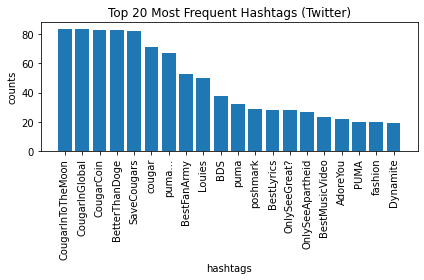

[('CougarInToTheMoon', 84), ('CougarInGlobal', 84), ('CougarCoin', 83), ('BetterThanDoge', 83), ('SaveCougars', 82), ('cougar', 71), ('puma…', 67), ('BestFanArmy', 53), ('Louies', 50), ('BDS', 38), ('puma', 32), ('poshmark', 29), ('BestLyrics', 28), ('OnlySeeGreat?', 28), ('OnlySeeApartheid', 27), ('BestMusicVideo', 23), ('AdoreYou', 22), ('PUMA', 20), ('fashion', 20), ('Dynamite', 19)]


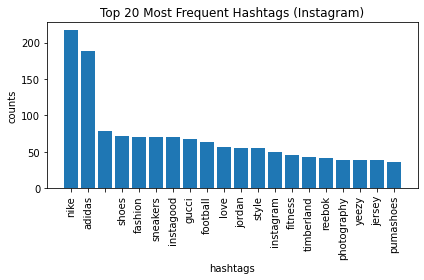

[('nike', 217), ('adidas', 189), ('', 78), ('shoes', 72), ('fashion', 71), ('sneakers', 70), ('instagood', 70), ('gucci', 68), ('football', 64), ('love', 56), ('jordan', 55), ('style', 55), ('instagram', 50), ('fitness', 45), ('timberland', 43), ('reebok', 42), ('photography', 39), ('yeezy', 39), ('jersey', 39), ('pumashoes', 36)]


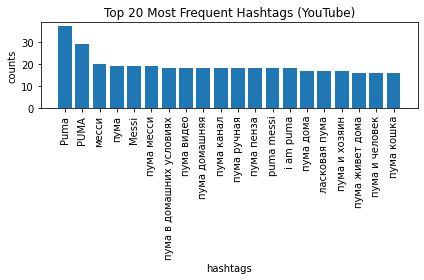

[('Puma', 37), ('PUMA', 29), ('месси', 20), ('пума', 19), ('Messi', 19), ('пума месси', 19), ('пума в домашних условиях', 18), ('пума видео', 18), ('пума домашняя', 18), ('пума канал', 18), ('пума ручная', 18), ('пума пенза', 18), ('puma messi', 18), ('i am puma', 18), ('пума дома', 17), ('ласковая пума', 17), ('пума и хозяин', 17), ('пума живет дома', 16), ('пума и человек', 16), ('пума кошка', 16)]


In [18]:
get_most_freq_hashtag(df_lst[1:], title_lst[1:])

#### Sensitive Scores

In [13]:
# Function used to process captions by lemmatization and removing punctuations and most/least frequent words
# return the processed captions as pandas series
def processTextCalculateSentiment(df):
    # Remove all hashtags, punctuations, and stopwords
    captions = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    captions = captions.apply(lambda x: ' '.join(re.sub("(#[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x) for x in x.split()))
    captions = captions.apply(lambda x: " ".join(x for x in x.split() if x not in nltk.corpus.stopwords.words('english')))
    
    # Remove most 10 common words
    freq = pd.Series(' '.join(captions).split()).value_counts()[:10]
    captions = captions.apply(lambda x: " ".join(x for x in x.split() if x not in list(freq.index)))
    # Remove 10 least frequent words
    least_freq = pd.Series(' '.join(captions).split()).value_counts()[-10:]
    captions = captions.apply(lambda x: " ".join(x for x in x.split() if x not in list(freq.index)))

    # Lemmatization
    captions = captions.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    captions.replace('', np.nan, inplace=True)
    captions.dropna(inplace=True)
    
    df['fully_proccessed_tokens'] = captions
    df['sentiment_score'] = df['fully_proccessed_tokens'].apply(lambda x: sentiment_score(str(x)))
    return df

# Function used to compute sentimental score from the input
def sentiment_score(text):
    sid = nltk.sentiment.vader.SentimentIntensityAnalyzer()
    return sid.polarity_scores(text)['compound']

In [18]:
def plotSentimentDistribution(df_list, title_list):
    for i in range(len(df_list)):
        df_list[i] = processTextCalculateSentiment(df_list[i])
        df_list[i]['sentiment_score'].hist()
        plt.xlabel('sentiment score')
        plt.ylabel('counts')
        plt.title('Sentiment Scores for ' + title_list[i])
        print('Average Sentiment Score for ' + title_list[i] + ' is ' + 
              str(df_list[i]['sentiment_score'].sum()/df_list[i].shape[0]))
        plt.show()

Average Sentiment Score for Reddit is 0.16644672686230247


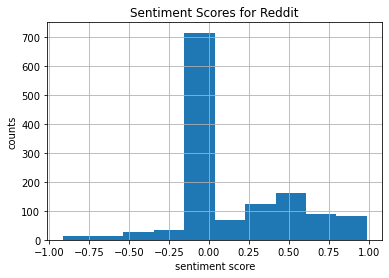

Average Sentiment Score for Twitter is 0.14061182844243791


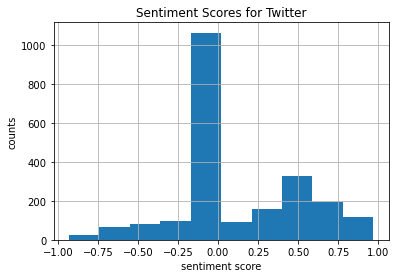

Average Sentiment Score for Instagram is 0.22984684579439252


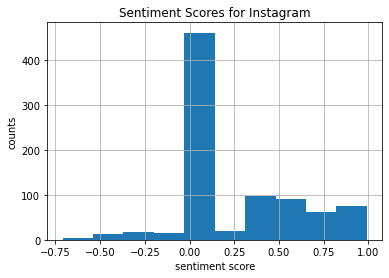

Average Sentiment Score for YouTube is 0.7084475247524753


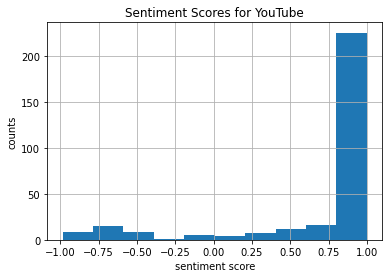

In [19]:
plotSentimentDistribution(df_lst, title_lst)

#### Word Frequency Distribution

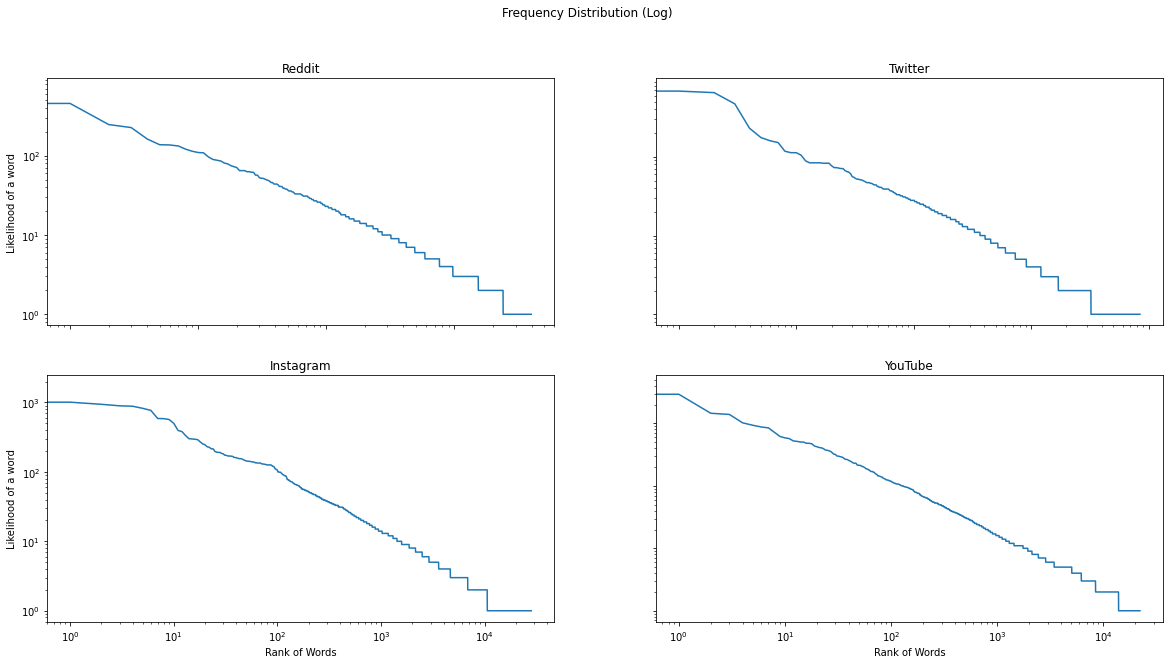

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle("Frequency Distribution (Log)")

axs[0, 0].plot(range(len(wordsCount_rdt)), wordsCount_rdt['count'])
axs[0, 0].set_title("Reddit")
axs[0, 1].plot(range(len(wordsCount_twt)), wordsCount_twt['count'])
axs[0, 1].set_title("Twitter")

axs[1, 0].plot(range(len(wordsCount_ins)), wordsCount_ins['count'])
axs[1, 0].set_title("Instagram")
axs[1, 1].plot(range(len(wordsCount_ytb)), wordsCount_ytb['count'])
axs[1, 1].set_title("YouTube")

for ax in axs.flat:
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set(xlabel='Rank of Words', ylabel='Likelihood of a word')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# set the spacing between subplots 
plt.show()

### Word Concordance

In [20]:
text = nltk.Text(token_twt) #Convert t_data into a Text class of nltk
CIndex = nltk.text.ConcordanceIndex(text) #Load the text into a ConcordanceIndex

In [21]:
# The surrounding words of 'enjoy'
CIndex.print_concordance('best')

Displaying 25 of 32 matches:
 @atletisaxonia @afcwxIdo Puma is the best option for Atleti puma seriously has 
elUsmani @HP @PUMA @BDSmovement OK My best wishes to you A long time ago in a la
 The puma home kits were terrible The best kit though was 2013 14 away kit @Goon
@Chilruno Mythra 's really trying her best RT @goal Jesse Lingard has been named
 through quite a few trainers and the best thing I ever did was start buying bra
is again Arsenal have had some of the best jerseys in recent years @Cansivx Ca n
hing puma stages and it truly was the best era RT @ComplexMusic THE REAL IS BACK
 This is a fake account Puma made the best kits last season overall they 're wel
s in all competitions this season the best ever single season return by a Premie
s rightly what Puma expects to be the best sell Nothing beats @PUMA RT @JamesMil
 gym kit via puma pumanigeria All the best @EcoPoo_Official It will be a blast Q
henz2 @milano_baba @aproko_doctor The best shoes to exercise in are Puma LQDCELL

In [22]:
text.common_contexts(['fit'])

skinny_which you_in fresh_same fully_squad fully_in


In [23]:
text.count('like')

84

In [26]:
# Make a plot to show each time a set of words occurs
list_of_words = ['love', 'hate', 'like', 'fit', 'worst', 'best', 'good']
token_lst = [token_rdt, token_twt, token_ins, token_ytb]
def plotWordsOccurance(token_list, title_list, df_list):
    for i in range(len(token_list)):
        text = nltk.Text(token_list[i])
        sns.reset_orig()
        nltk.draw.dispersion.dispersion_plot(text, list_of_words, 
                                             title="Word Occurances in {}".format(title_list[i]))
        sns.set()
         
        num_strong_pos = text.count('love') + text.count('best')
        num_strong_neg = text.count('hate') + text.count('worst')
        num_weak_pos = text.count('like') + text.count('good')
        total_words_count = df_list[i]['word_counts'].sum()
        print('Frequency Strong Positive Words: ' + str(num_strong_pos/total_words_count))
        print('Frequency Strong Negative Words: ' + str(num_strong_neg/total_words_count))
        print('Frequency Weak Positive Words: ' + str(num_weak_pos/total_words_count))
        print('Frequency Emotion Words: ' + str((num_weak_pos+num_strong_pos+num_strong_neg)/total_words_count))

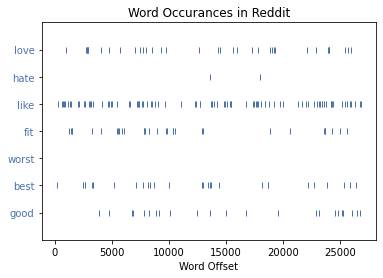

Frequency Strong Positive Words: 0.002425988400742959
Frequency Strong Negative Words: 7.581213752321746e-05
Frequency Weak Positive Words: 0.004283385770061787
Frequency Emotion Words: 0.006785186308327963


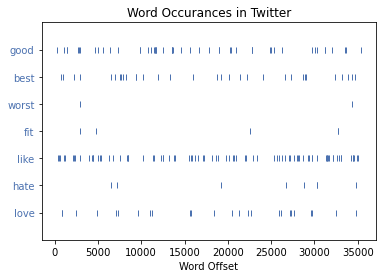

Frequency Strong Positive Words: 0.001659533583719102
Frequency Strong Negative Words: 0.0002911462427577372
Frequency Weak Positive Words: 0.003930474277229453
Frequency Emotion Words: 0.005881154103706291


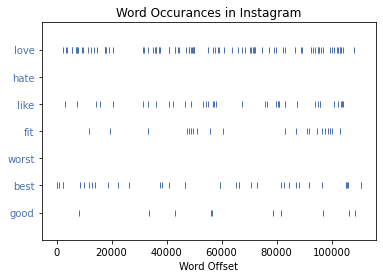

Frequency Strong Positive Words: 0.00396910864281099
Frequency Strong Negative Words: 0.0
Frequency Weak Positive Words: 0.001476877634534322
Frequency Emotion Words: 0.005445986277345312


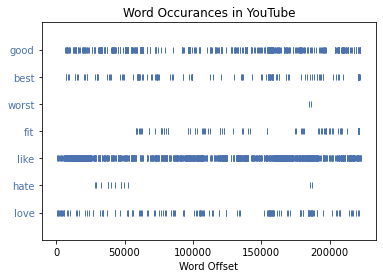

Frequency Strong Positive Words: 0.00119064137971165
Frequency Strong Negative Words: 7.60936220116468e-05
Frequency Weak Positive Words: 0.008182302413958255
Frequency Emotion Words: 0.009449037415681552


In [27]:
plotWordsOccurance(token_lst, title_lst, df_lst)

#### Word Distribution

#### (1) word frequency distribution (word lengths)

In [29]:
def wordDistributionLength(df_list, title_list, word_length, num_words=20):
    for i in range(len(df_list)):
        whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in df_list[i]['normalized_tokens'].sum()))
        whcfdist[word_length].plot(num_words, title=title_list[i])

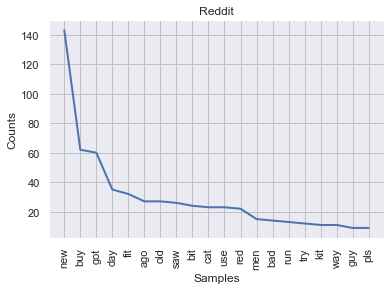

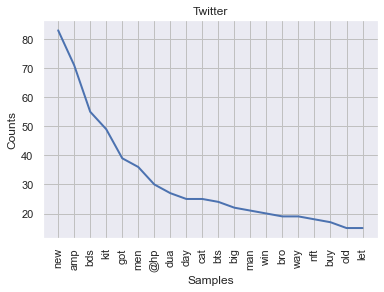

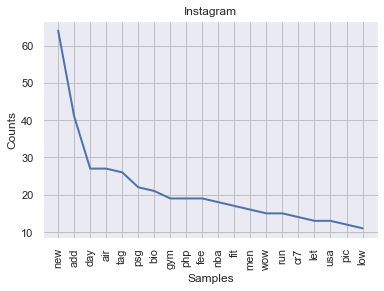

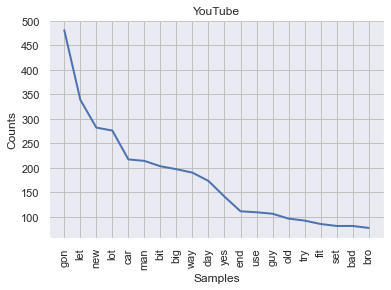

In [30]:
wordDistributionLength(df_lst, title_lst, 3)

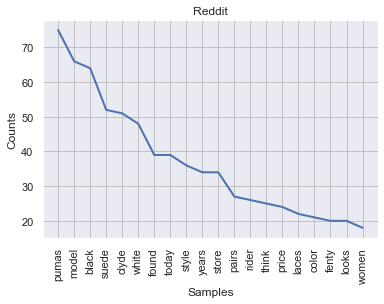

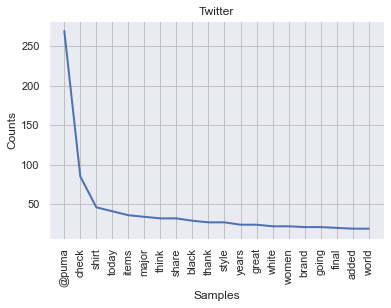

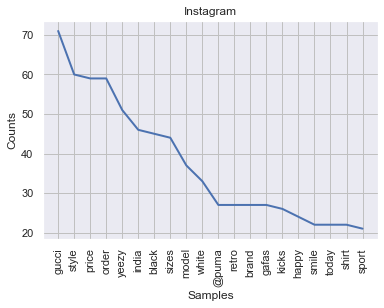

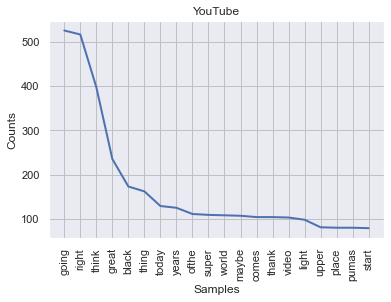

In [31]:
wordDistributionLength(df_lst, title_lst, 5)

#### (2) word frequency distribution (POS)

In [32]:
def wordDistributionPOS(df_list, title_list, pos, num_words=20):
    freqDict = {}
    for i in range(len(df_list)):
        df_list[i]['normalized_tokens_POS'] = [nltk.pos_tag(t) for t in df_list[i]['normalized_tokens']]
        POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in df_list[i]['normalized_tokens_POS'].sum())
        POStoWord[pos].plot(num_words, title=title_list[i])
        freqDict[title_list[i]] = POStoWord[pos].most_common(10)
    return pd.DataFrame(freqDict)

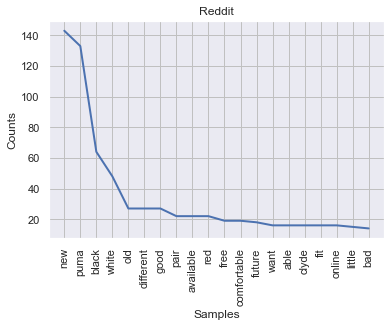

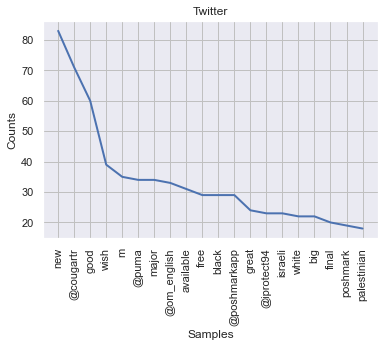

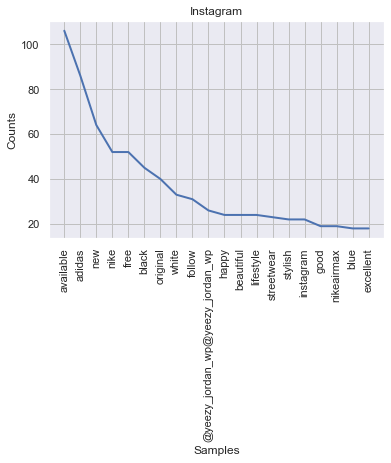

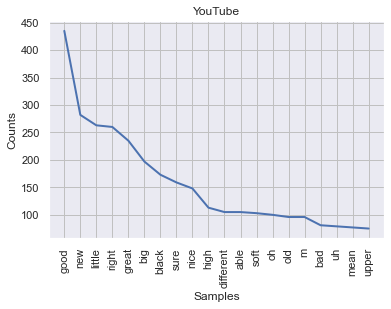

,Reddit,Twitter,Instagram,YouTube
0,"(new, 143)","(new, 83)","(available, 106)","(good, 435)"
1,"(puma, 133)","(@cougartr, 71)","(adidas, 86)","(new, 282)"
2,"(black, 64)","(good, 60)","(new, 64)","(little, 263)"
3,"(white, 48)","(wish, 39)","(nike, 52)","(right, 260)"
4,"(old, 27)","(m, 35)","(free, 52)","(great, 235)"
5,"(different, 27)","(@puma, 34)","(black, 45)","(big, 197)"
6,"(good, 27)","(major, 34)","(original, 40)","(black, 173)"
7,"(pair, 22)","(@om_english, 33)","(white, 33)","(sure, 159)"
8,"(available, 22)","(available, 31)","(follow, 31)","(nice, 148)"
9,"(red, 22)","(free, 29)","(@yeezy_jordan_wp@yeezy_jordan_wp, 26)","(high, 113)"


In [33]:
wordDistributionPOS(df_lst, title_lst, 'JJ')

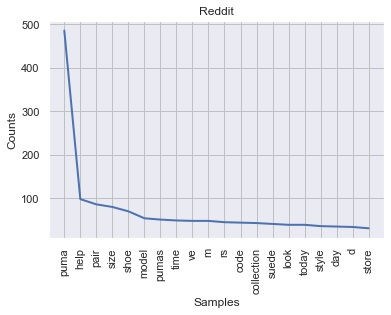

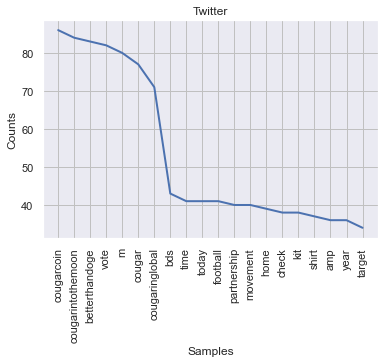

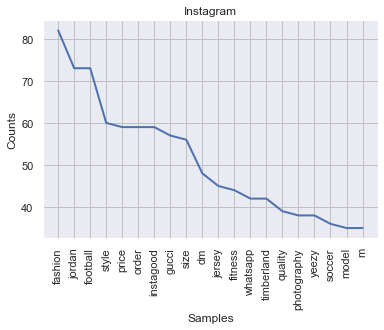

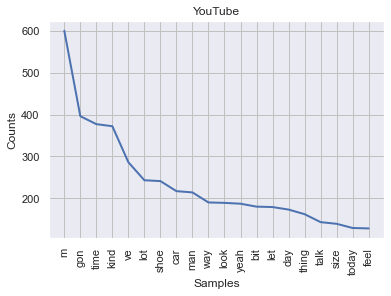

,Reddit,Twitter,Instagram,YouTube
0,"(puma, 485)","(cougarcoin, 86)","(fashion, 82)","(m, 600)"
1,"(help, 98)","(cougarintothemoon, 84)","(jordan, 73)","(gon, 396)"
2,"(pair, 86)","(betterthandoge, 83)","(football, 73)","(time, 377)"
3,"(size, 80)","(vote, 82)","(style, 60)","(kind, 372)"
4,"(shoe, 70)","(m, 80)","(price, 59)","(ve, 286)"
5,"(model, 54)","(cougar, 77)","(order, 59)","(lot, 243)"
6,"(pumas, 51)","(cougaringlobal, 71)","(instagood, 59)","(shoe, 241)"
7,"(time, 49)","(bds, 43)","(gucci, 57)","(car, 217)"
8,"(ve, 48)","(time, 41)","(size, 56)","(man, 214)"
9,"(m, 48)","(today, 41)","(dm, 48)","(way, 190)"


In [34]:
wordDistributionPOS(df_lst, title_lst, 'NN')

#### (3) conditional probability distribution (word length)

In [35]:
def wordProbDistribLength(df_list, title_list, word_length):
    most_common = {}
    for i in range(len(df_list)):
        whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in df_list[i]['normalized_tokens'].sum()))
        whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)
        most_common_word = whcpdist[word_length].max()
        most_common[title_list[i]] = [most_common_word, whcpdist[word_length].prob(most_common_word)]
    return pd.DataFrame(most_common)

In [36]:
wordProbDistribLength(df_lst, title_lst, 5)

,Reddit,Twitter,Instagram,YouTube
0,pumas,@puma,gucci,going
1,0.0323202,0.0858144,0.0217722,0.0326895


In [37]:
wordProbDistribLength(df_lst, title_lst, 6)

,Reddit,Twitter,Instagram,YouTube
0,bought,cougar,adidas,little
1,0.0213976,0.0298077,0.0754988,0.0179473


#### (4) conditional probability distribution (POS)

In [38]:
def wordProbDistribPOS(df_list, title_list, pos):
    most_common = {}
    for i in range(len(df_list)):
        df_list[i]['normalized_tokens_POS'] = [nltk.pos_tag(t) for t in df_list[i]['normalized_tokens']]
        POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in df_list[i]['normalized_tokens_POS'].sum())
        whcpdist_POStoWord = nltk.ConditionalProbDist(POStoWord, nltk.ELEProbDist)
        most_common_word = whcpdist_POStoWord[pos].max()
        most_common[title_list[i]] = [most_common_word, whcpdist_POStoWord[pos].prob(most_common_word)]
    return pd.DataFrame(most_common)

In [39]:
wordProbDistribPOS(df_lst, title_lst, 'JJ')

,Reddit,Twitter,Instagram,YouTube
0,new,new,available,good
1,0.0561095,0.019754,0.0200887,0.0182363


In [40]:
wordProbDistribPOS(df_lst, title_lst, 'NN')

,Reddit,Twitter,Instagram,YouTube
0,puma,cougarcoin,fashion,m
1,0.0799111,0.00894565,0.00609869,0.0127334


#### (5) Word Cloud

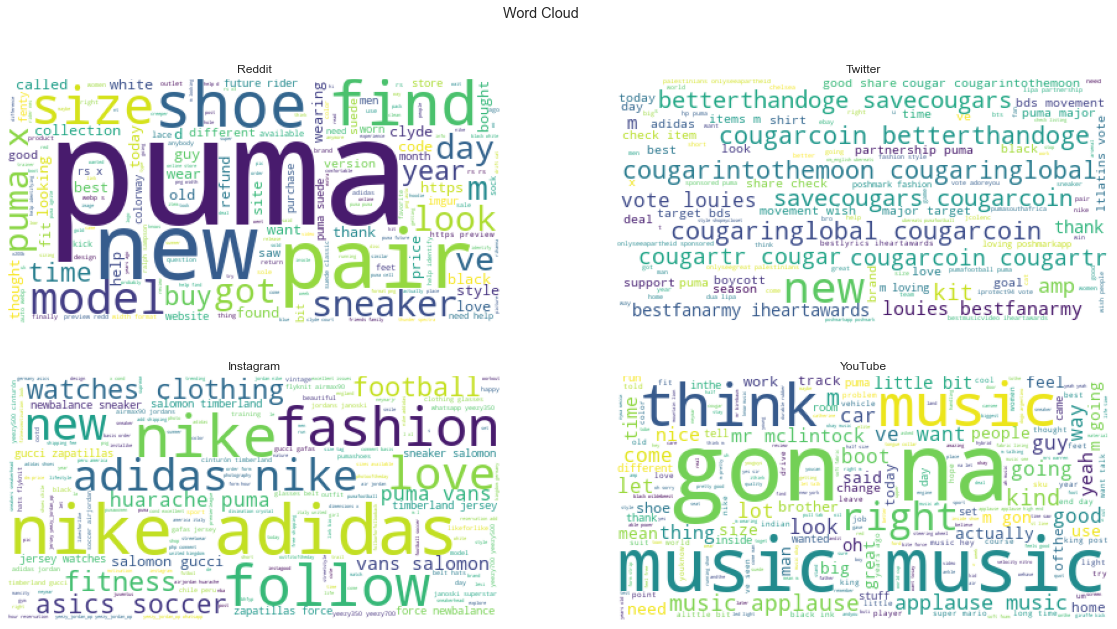

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle("Word Cloud")

wc_1 = wordcloud.WordCloud(background_color="white", max_words=500, mode='RGBA').generate(' '.join(reddit['normalized_tokens'].sum()))
axs[0, 0].imshow(wc_1)
axs[0, 0].set_title("Reddit")
wc_2 = wordcloud.WordCloud(background_color="white", max_words=500, mode='RGBA').generate(' '.join(twitter['normalized_tokens'].sum()))
axs[0, 1].imshow(wc_2)
axs[0, 1].set_title("Twitter")

wc_3 = wordcloud.WordCloud(background_color="white", max_words=500, mode='RGBA').generate(' '.join(ins['normalized_tokens'].sum()))
axs[1, 0].imshow(wc_3)
axs[1, 0].set_title("Instagram")
wc_4 = wordcloud.WordCloud(background_color="white", max_words=500, mode='RGBA').generate(' '.join(youtube['normalized_tokens'].sum()))
axs[1, 1].imshow(wc_4)
axs[1, 1].set_title("YouTube")

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

#### Bigrams

In [42]:
def bigrams(df_list, title_list):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    bigram_dict = {}
    for i in range(len(df_list)):
        bigrams = nltk.collocations.BigramCollocationFinder.from_words(df_list[i]['normalized_tokens'].sum())
        bigram_dict[title_list[i]] = bigrams.score_ngrams(bigram_measures.student_t)[:10]
    return pd.DataFrame(bigram_dict)

In [43]:
bigrams(df_lst, title_lst)

,Reddit,Twitter,Instagram,YouTube
0,"((puma, x), 6.667948948257356)","((cougarintothemoon, cougaringlobal), 9.124993...","((|, |), 9.12739737052483)","((gon, na), 21.829436220558602)"
1,"((rs, x), 4.576066388796417)","((cougaringlobal, cougarcoin), 9.123558975800663)","((nike, adidas), 8.105882316920662)","((mr, mclintock), 9.569712671345911)"
2,"((need, help), 4.390575932919014)","((betterthandoge, savecougars), 9.070990358286...","((😘, 😘), 6.906475723669494)","((little, bit), 9.378488068451757)"
3,"((help, identify), 4.181232250026855)","((cougarcoin, betterthandoge), 9.069089480172646)","((🔥, 🔥), 5.830055153600464)","((m, gon), 8.51397183656937)"
4,"((future, rider), 3.856788819510506)","((savecougars, @cougarcoin), 9.015702138652276)","((▬, ▬), 5.190243867320188)","((m, going), 7.059572711991517)"
5,"((thunder, spectra), 3.735339052492641)","((@cougarcoin, @cougartr), 8.448544722313175)","((gafas, jersey), 5.186792185729638)","((super, mario), 5.9085774248855705)"
6,"((friends, family), 3.7345653789071753)","((@cougartr, cougar), 8.391829615057185)","((whatsapp, ➕), 5.185164318429291)","((ve, seen), 5.666151416648731)"
7,"((ralph, sampson), 3.599864215716585)","((vote, louies), 7.43396394175142)","((gucci, gafas), 5.181705100416055)","((alittle, bit), 5.6415458511135155)"
8,"((clyde, court), 3.5884900962217774)","((louies, bestfanarmy), 6.976303494116857)","((timberland, gucci), 5.173143724243861)","((long, time), 5.201014899001773)"
9,"((puma, rs), 3.45115416459462)","((cougar, cougarintothemoon), 6.7325853390060315)","((➕, 15060620481#yeezy350#yeezy700#yeezy500#ci...","((black, ink), 5.088822402439969)"


#### Trigrams

In [44]:
def trigrams(df_list, title_list):
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    trigram_dict = {}
    for i in range(len(df_list)):
        trigrams = nltk.collocations.TrigramCollocationFinder.from_words(df_list[i]['normalized_tokens'].sum())
        trigram_dict[title_list[i]] = trigrams.score_ngrams(trigram_measures.student_t)[:10]
    return pd.DataFrame(trigram_dict)

In [45]:
trigrams(df_lst, title_lst)

,Reddit,Twitter,Instagram,YouTube
0,"((puma, rs, x), 2.8174483996629234)","((cougarintothemoon, cougaringlobal, cougarcoi...","((|, |, |), 8.83161664465785)","((m, gon, na), 8.997733464412761)"
1,"((😆, 😆, 😆), 2.449485181293608)","((cougarcoin, betterthandoge, savecougars), 9....","((😘, 😘, 😘), 6.244939473990892)","((soft, fabric, lining), 3.741652568794481)"
2,"((x, rhude, alteration), 2.449473349930035)","((cougaringlobal, cougarcoin, betterthandoge),...","((timberland, gucci, gafas), 5.196128094900456)","((gon, na, let), 3.7396870616560713)"
3,"((future, rider, nes), 2.4494712117317987)","((betterthandoge, savecougars, @cougarcoin), 9...","((gucci, gafas, jersey), 5.196126397611653)","((gon, na, throw), 3.4639446686507775)"
4,"((x, porsche, drop), 2.4494654570748176)","((savecougars, @cougarcoin, @cougartr), 8.4851...","((▬, ▬, ▬), 5.099012911499131)","((accounts, zebraskilling, lionsi), 3.31662475..."
5,"((puma, california, drive), 2.449337693130832)","((@cougarcoin, @cougartr, cougar), 8.426001185...","((➕, 15060620481#yeezy350#yeezy700#yeezy500#ci...","((alligators, crocodiles, matethe), 3.31662475..."
6,"((puma, thunder, spectra), 2.448930960310806)","((vote, louies, bestfanarmy), 6.928055863705877)","((@yeezy_jordan_wp@yeezy_jordan_wp, whatsapp, ...","((angulates, relatedto, goatsand), 3.316624752..."
7,"((puma, x, porsche), 2.4477411717811965)","((@cougartr, cougar, cougarintothemoon), 6.782...","((whatsapp, ➕, 15060620481#yeezy350#yeezy700#y...","((animalscan, alligators, crocodiles), 3.31662..."
8,"((puma, x, rhude), 2.447522600405949)","((cougar, cougarintothemoon, cougaringlobal), ...",((15060620481#yeezy350#yeezy700#yeezy500#cintu...,"((asflapping, earsand, rubbing), 3.31662475263..."
9,"((puma, x, stampd), 2.4473040290307013)","((louies, bestfanarmy, iheartawards), 6.402971...","((dimensions, x, cond), 4.6904061069165435)","((beastcurve, forwardthen, downward), 3.316624..."


#### KL Divergence

In [46]:
rdt_words = set(reddit['normalized_tokens'].sum())
twt_words = set(twitter['normalized_tokens'].sum())
ins_words = set(ins['normalized_tokens'].sum())
ytb_words = set(youtube['normalized_tokens'].sum())

overlapWords = rdt_words & twt_words & ins_words & ytb_words
overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}

In [47]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

rdtProbArray = makeProbsArray(reddit['normalized_tokens'], overlapWordsDict)
twtProbArray = makeProbsArray(twitter['normalized_tokens'], overlapWordsDict)
insProbArray = makeProbsArray(ins['normalized_tokens'], overlapWordsDict)
ytbProbArray = makeProbsArray(youtube['normalized_tokens'], overlapWordsDict)

In [48]:
# Calculate divergences
rdt_twt_divergence = scipy.stats.entropy(rdtProbArray, twtProbArray)
print("Reddit & Twitter: {}".format(rdt_twt_divergence))
rdt_ins_divergence = scipy.stats.entropy(rdtProbArray, insProbArray)
print("Reddit & Instagra: {}".format(rdt_ins_divergence))
rdt_ytb_divergence = scipy.stats.entropy(rdtProbArray, ytbProbArray)
print("Reddit & YouTube: {}".format(rdt_ytb_divergence))

twt_ins_divergence = scipy.stats.entropy(twtProbArray, insProbArray)
print("Twitter & Instagram: {}".format(twt_ins_divergence))
twt_ytb_divergence = scipy.stats.entropy(twtProbArray, ytbProbArray)
print("Twitter & YouTube: {}".format(twt_ytb_divergence))
ins_ytb_divergence = scipy.stats.entropy(insProbArray, ytbProbArray)
print("Instagram & YouTube: {}".format(ins_ytb_divergence))

Reddit & Twitter: 0.5965282338470894
Reddit & Instagra: 0.91247898534347
Reddit & YouTube: 0.8169145402774871
Twitter & Instagram: 0.7103668787553028
Twitter & YouTube: 0.81210982925841
Instagram & YouTube: 1.4290695928834283


In [49]:
from IPython.display import display

# Elementwise calculation and see which words best distinguish the two corpora
def wordMostDistinguish(probArray_list, title_list, num_words=10):
    kl_df = pd.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
    kl_df = kl_df.sort_index()
    for i in range(len(probArray_list)):
        print(title_list[i])
        result = {}
        for j in range(len(probArray_list)):
            if (probArray_list[j] != probArray_list[i]).all():
                divergence_ew = scipy.special.kl_div(probArray_list[j], probArray_list[i])
                wd_df = kl_df
                wd_df['elementwise divergence'] = divergence_ew
                wd_df = wd_df.sort_values(by='elementwise divergence', ascending=False)[:num_words]
                wd_df[" vs. " + title_list[j]] = wd_df['word'] + ", " + wd_df['elementwise divergence'].astype(str)
                wd_df.drop(columns=['word', 'elementwise divergence'], inplace=True)
                wd_df.reset_index(drop=True, inplace=True)
                result.update(wd_df.to_dict())
        display(pd.DataFrame.from_dict(result))

In [50]:
probArray_lst = [rdtProbArray, twtProbArray, insProbArray, ytbProbArray]
wordMostDistinguish(probArray_lst, title_lst)

Reddit


,vs. Twitter,vs. Instagram,vs. YouTube
0,"cougar, 0.039966926662233136","nike, 0.1384769210841292","na, 0.039915520571710744"
1,"check, 0.024833253277667375","adidas, 0.06887129360518453","gon, 0.039915520571710744"
2,"find, 0.017135795067249014","fashion, 0.042273968691123306","oh, 0.023539156564876342"
3,"wish, 0.014772447829242679","|, 0.03269965243263415","going, 0.022513341497749723"
4,"kits, 0.012760482571711803","jordan, 0.032365292050118656","kind, 0.021893772421792006"
5,"season, 0.012146594019994267","jersey, 0.024652516005274717","right, 0.0195690889311528"
6,"fashion, 0.01160634591639968","india, 0.024652516005274717","lot, 0.015605537834095858"
7,"jersey, 0.009813766520545116","football, 0.020397506210576635","let, 0.015550989460086494"
8,"pair, 0.009376568194679922","soccer, 0.01840349310531962","x, 0.014195289640957507"
9,"|, 0.008979881956310857","find, 0.01721311696228557","find, 0.014144368428049456"


Twitter


,vs. Reddit,vs. Instagram,vs. YouTube
0,"find, 0.04192050788987127","nike, 0.07862023289445146","gon, 0.025148510594840006"
1,"pumas, 0.019946468326265593","adidas, 0.03397827825478648","na, 0.018726003844335443"
2,"pair, 0.016383942830721088","order, 0.021448923755042076","kind, 0.01659368242454822"
3,"code, 0.014956135610538254","india, 0.014773896745415648","right, 0.01568955405246972"
4,"cougar, 0.012683384325235482","explore, 0.01433544621983989","going, 0.012431683736043891"
5,"check, 0.011190298959523677","jordan, 0.013057342937277639","cougar, 0.011057584283132357"
6,"collection, 0.01114525735796576","sneakers, 0.011734622112361526","bit, 0.010519327159357135"
7,"help, 0.010324881616183994","retro, 0.011294578523260617","check, 0.009840026066658913"
8,"pairs, 0.009593037982828349","cougar, 0.010830776424779845","want, 0.009822449490104253"
9,"found, 0.009545777682623035","check, 0.01080798490990299","guys, 0.00867109015153073"


Instagram


,vs. Reddit,vs. Twitter,vs. YouTube
0,"help, 0.06233567819663363","nike, 0.036500175765965634","gon, 0.05520453111858811"
1,"nike, 0.04615207935363911","cougar, 0.02588217771326197","na, 0.04440266347619588"
2,"find, 0.042362056814642654","kits, 0.02511690685120134","nike, 0.043089915919275565"
3,"pumas, 0.03072692231232971","check, 0.023190609771597454","adidas, 0.036228112837228064"
4,"adidas, 0.030720256221584724","adidas, 0.020177632298158808","going, 0.03464130590407234"
5,"pair, 0.029808241159608024","items, 0.013077398496641496","kind, 0.0312735108480496"
6,"shoe, 0.01888558034036987","sponsored, 0.012979602530878374","ve, 0.025433984984012573"
7,"d, 0.017334805652633466","wish, 0.011816136049010271","want, 0.01956648743385007"
8,"found, 0.01621751444847989","list, 0.011130989964448279","actually, 0.018951982771569367"
9,"bought, 0.01621751444847989","people, 0.010847236431985959","right, 0.017895929712747866"


YouTube


,vs. Reddit,vs. Twitter,vs. Instagram
0,"x, 0.03414143979947631","kits, 0.03377360913749559","nike, 0.1134716870862754"
1,"find, 0.02853523695738264","cougar, 0.027135253085281967","adidas, 0.10225070388958811"
2,"d, 0.025251686192257147","loving, 0.023852280661747754","jordan, 0.054143468993570865"
3,"code, 0.021989999086438623","sponsored, 0.021958185851022303","available, 0.04612124232367516"
4,"pair, 0.018484429808810245","shirt, 0.02032011594939222","jersey, 0.032008715892437735"
5,"buy, 0.01740697488255352","kit, 0.019692188346684757","sneakers, 0.030832706411771483"
6,"na, 0.013672519192561343","check, 0.019531150905910278","india, 0.028667671157903273"
7,"gon, 0.013672519192561343","s, 0.016436814335523325","fashion, 0.027292236856795632"
8,"rs, 0.013550849532352142","chelsea, 0.014657395891252645","sizes, 0.02307171132660356"
9,"help, 0.012949493691177828","$, 0.014640958334595713","shipping, 0.02232403782922988"


In [28]:
# Functions to calculate divergence and distances.
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pd.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pd.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

#### KL Distance

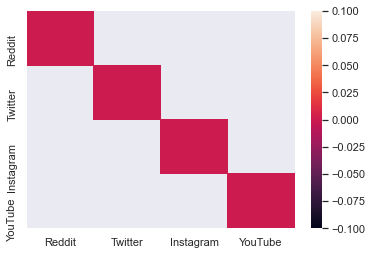

In [52]:
# Plot KL distances heatmap
L = []
for p in df_lst:
    l = []
    for q in df_lst:
        l.append(Divergence(p['text'],q['text'], difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = title_lst, index = title_lst)
ax = sns.heatmap(div)
plt.show()

#### $\chi^2$ Distance

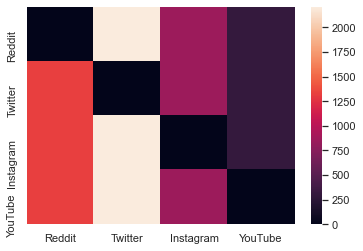

In [53]:
L = []
for p in df_lst:
    l = []
    for q in df_lst:
        l.append(Divergence(p['text'],q['text'], difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = title_lst, index = title_lst)
ax = sns.heatmap(div)
plt.show()

#### KS Distance

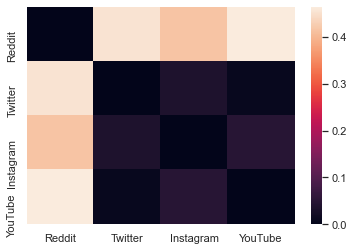

In [54]:
L = []
for p in df_lst:
    l = []
    for q in df_lst:
        l.append(Divergence(p['text'],q['text'], difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = title_lst, index = title_lst)
ax = sns.heatmap(div)
plt.show()

#### Wasserstein Distance

             Reddit   Twitter  Instagram   YouTube
Reddit     0.000000  0.682725   0.637257  0.655044
Twitter    0.682725  0.000000   0.121904  0.060824
Instagram  0.637257  0.121904   0.000000  0.141333
YouTube    0.655044  0.060824   0.141333  0.000000


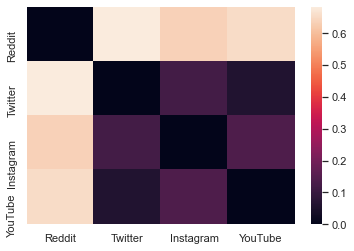

In [30]:
L = []
for p in df_lst:
    l = []
    for q in df_lst:
        l.append(Divergence(p['text'],q['text'], difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = title_lst, index = title_lst)
print(div)
ax = sns.heatmap(div)
plt.show()

#### Multidimensional Scaling

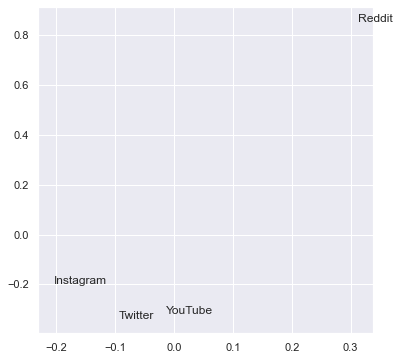

In [31]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(title_lst):
    ax.annotate(txt, (x[i],y[i]))

#### Jensen-Shannon Divergence

In [57]:
# Calculate Jensen-Shannon Divergences
rdt_twt_JSD = scipy.spatial.distance.jensenshannon(rdtProbArray, twtProbArray)
print("Reddit & Twitter: {}".format(rdt_twt_JSD))
rdt_ins_JSD = scipy.spatial.distance.jensenshannon(rdtProbArray, insProbArray)
print("Reddit & Instagram: {}".format(rdt_ins_JSD))
rdt_ytb_JSD = scipy.spatial.distance.jensenshannon(rdtProbArray, ytbProbArray)
print("Reddit & YouTube: {}\n".format(rdt_ytb_JSD))

twt_ins_JSD = scipy.spatial.distance.jensenshannon(twtProbArray, insProbArray)
print("Twitter & Instagram: {}".format(twt_ins_JSD))
twt_ytb_JSD = scipy.spatial.distance.jensenshannon(twtProbArray, ytbProbArray)
print("Twitter & YouTube: {}".format(twt_ytb_JSD))
ins_ytb_JSD = scipy.spatial.distance.jensenshannon(insProbArray, ytbProbArray)
print("Instagram & YouTube: {}\n".format(ins_ytb_JSD))

Reddit & Twitter: 0.36577845240496265
Reddit & Instagram: 0.437249199877202
Reddit & YouTube: 0.4073781162464284

Twitter & Instagram: 0.3910748437715284
Twitter & YouTube: 0.3831920560019869
Instagram & YouTube: 0.5030368443037116



## Discovering Patterns: Clusters & Topics 

#### Selecting Cluster Number

In [58]:
def getTFVects(df):
    TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.50, max_features=1000, 
                                                           min_df=3, stop_words='english', norm='l2')
    TFVects = TFVectorizer.fit_transform(df['text'])
    return TFVectorizer, TFVects

In [59]:
from sklearn.cluster import KMeans
def plotSilhouette_revised(n_clusters, X, reduced_data):
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

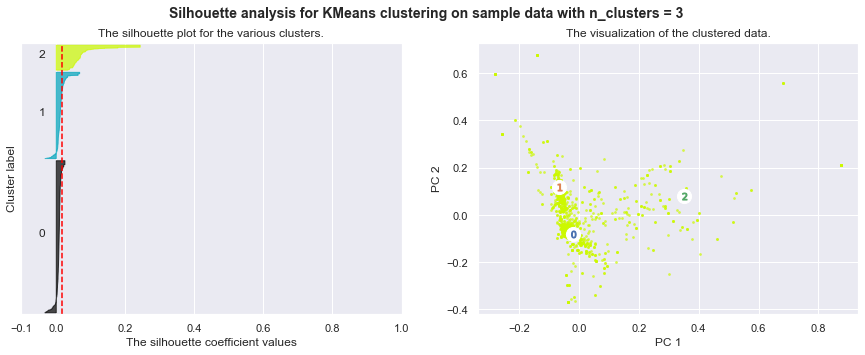

For n_clusters = 3, The average silhouette_score is : 0.017


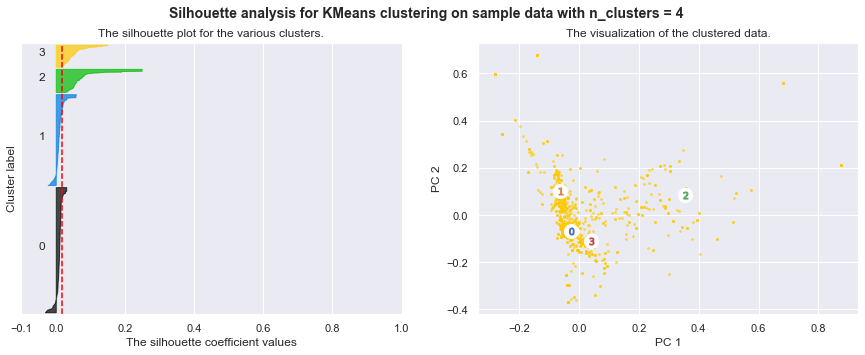

For n_clusters = 4, The average silhouette_score is : 0.019


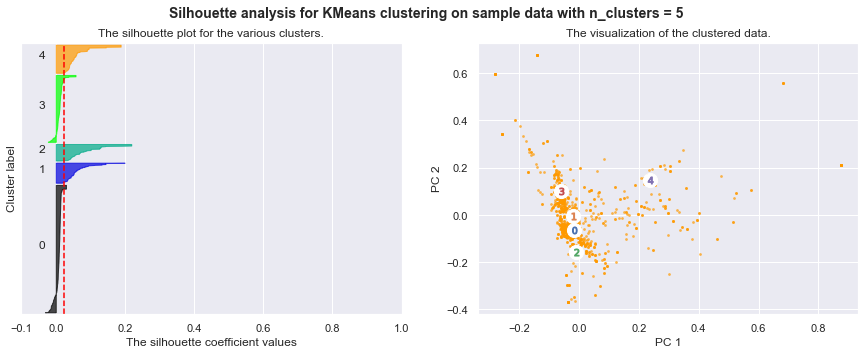

For n_clusters = 5, The average silhouette_score is : 0.024


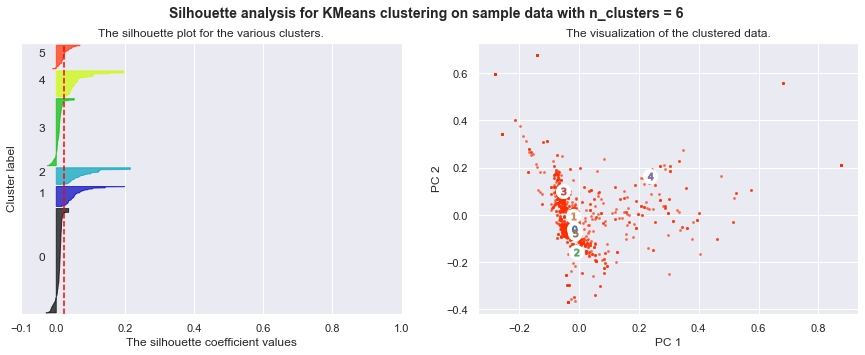

For n_clusters = 6, The average silhouette_score is : 0.025


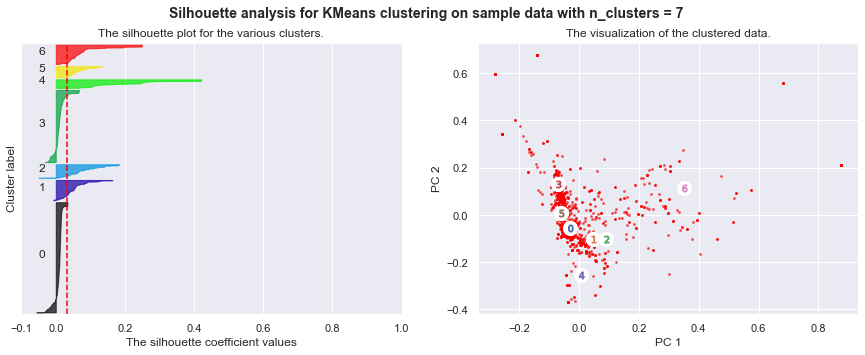

For n_clusters = 7, The average silhouette_score is : 0.032


In [60]:
cluster_num = [3, 4, 5, 6, 7]
rdtTFVectorizer, rdtTFVects = getTFVects(reddit)
for n in cluster_num:
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(rdtTFVects.toarray())
    reduced_data = pca.transform(rdtTFVects.toarray())
    X = rdtTFVects.toarray()
    plotSilhouette_revised(n, X, reduced_data)

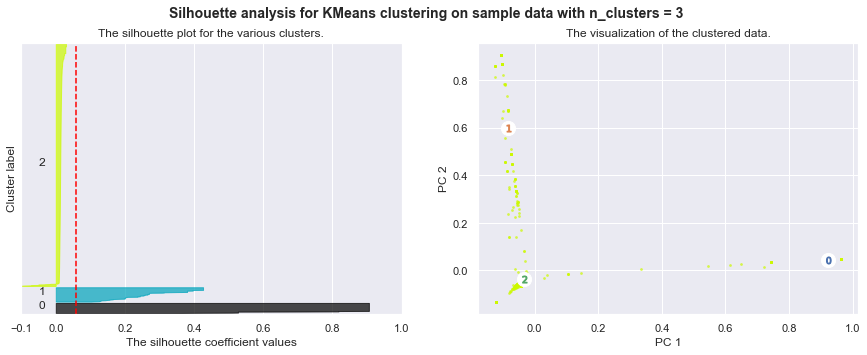

For n_clusters = 3, The average silhouette_score is : 0.059


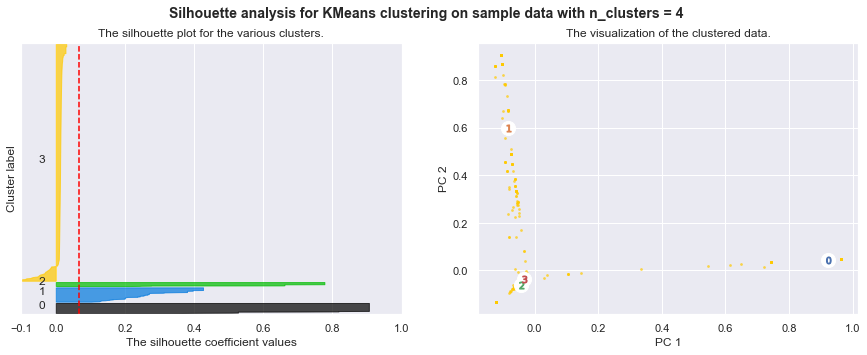

For n_clusters = 4, The average silhouette_score is : 0.066


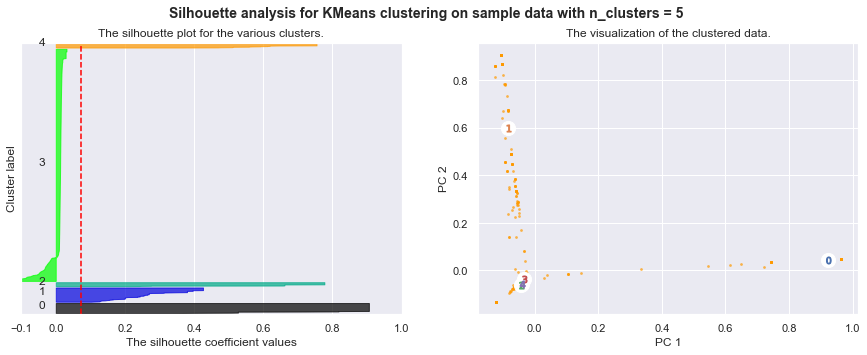

For n_clusters = 5, The average silhouette_score is : 0.073


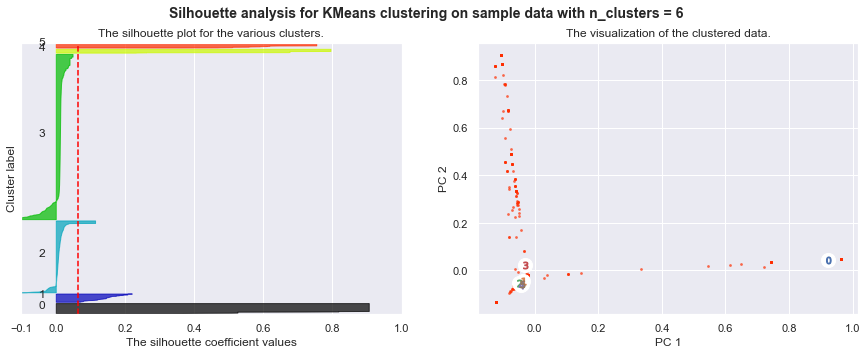

For n_clusters = 6, The average silhouette_score is : 0.064


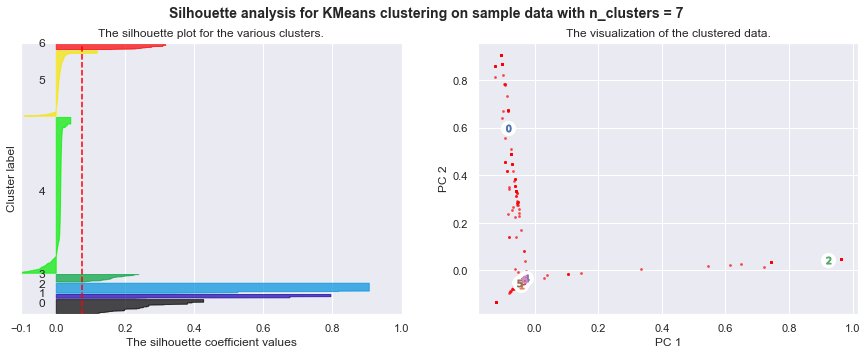

For n_clusters = 7, The average silhouette_score is : 0.075


In [61]:
twtTFVectorizer, twtTFVects = getTFVects(twitter)
for n in cluster_num:
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(twtTFVects.toarray())
    reduced_data = pca.transform(twtTFVects.toarray())
    X = twtTFVects.toarray()
    plotSilhouette_revised(n, X, reduced_data)

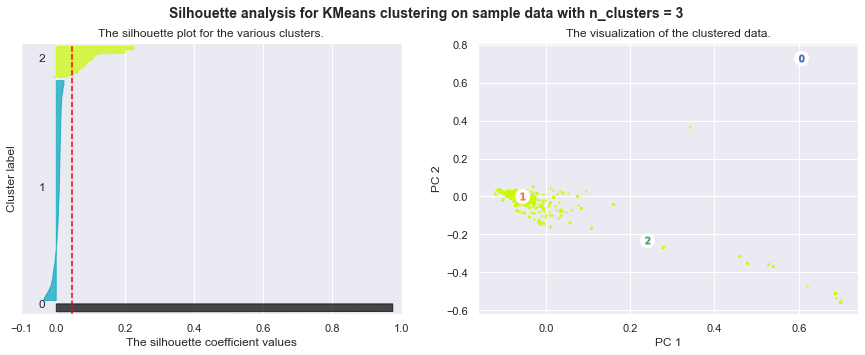

For n_clusters = 3, The average silhouette_score is : 0.047


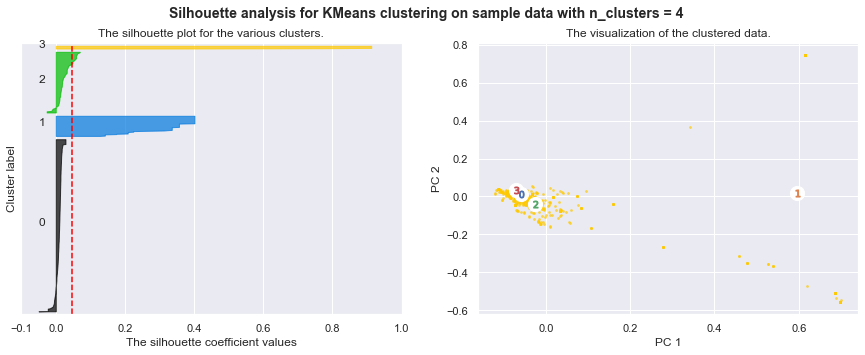

For n_clusters = 4, The average silhouette_score is : 0.047


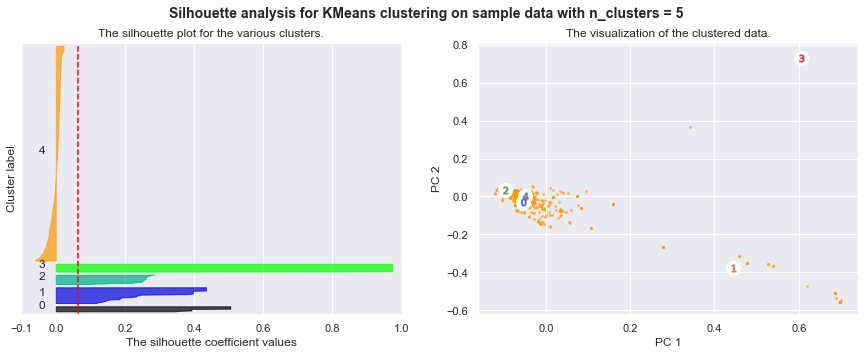

For n_clusters = 5, The average silhouette_score is : 0.065


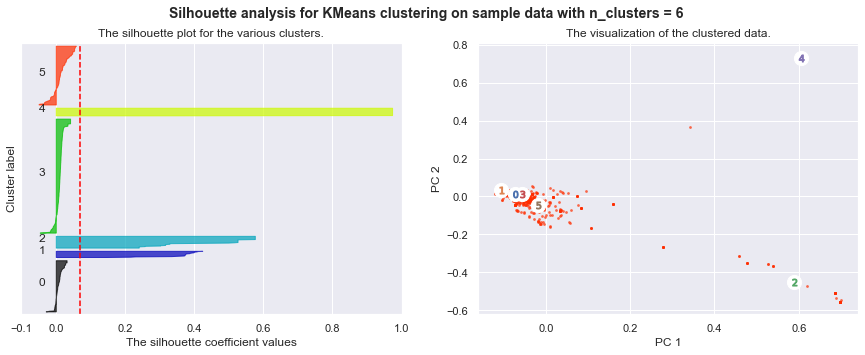

For n_clusters = 6, The average silhouette_score is : 0.070


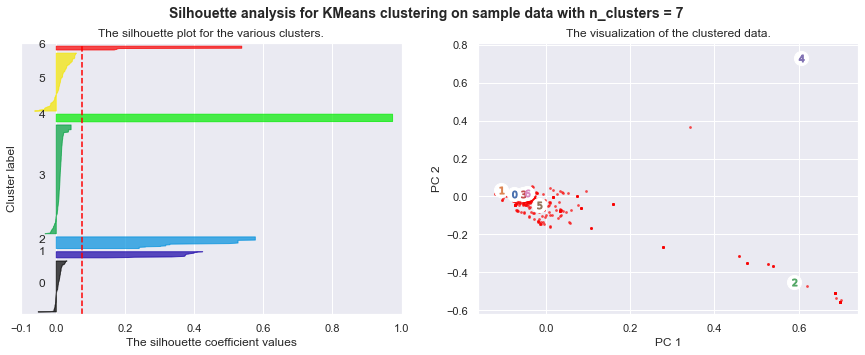

For n_clusters = 7, The average silhouette_score is : 0.075


In [62]:
insTFVectorizer, insTFVects = getTFVects(ins)
for n in cluster_num:
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(insTFVects.toarray())
    reduced_data = pca.transform(insTFVects.toarray())
    X = insTFVects.toarray()
    plotSilhouette_revised(n, X, reduced_data)

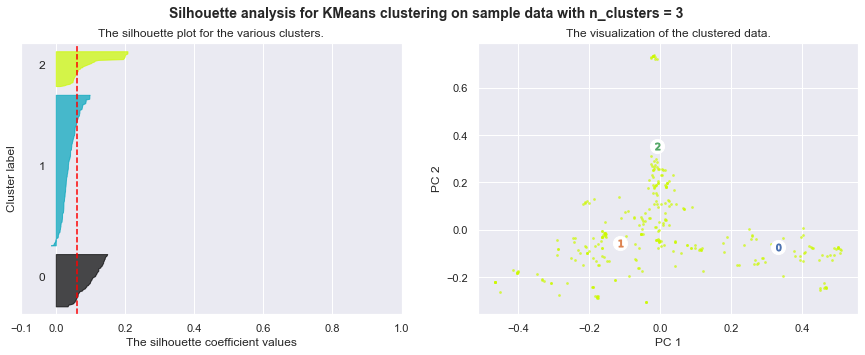

For n_clusters = 3, The average silhouette_score is : 0.060


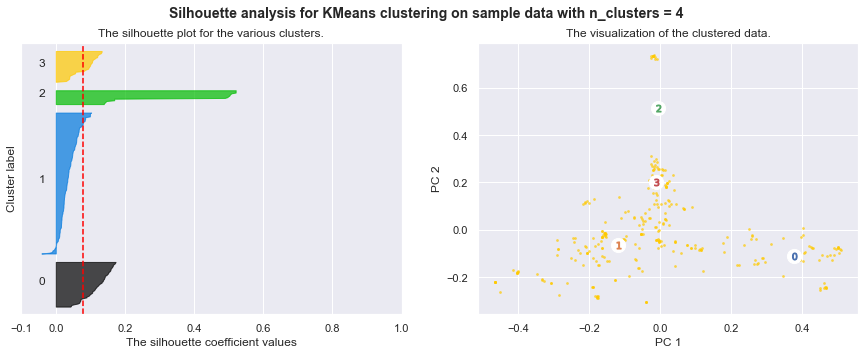

For n_clusters = 4, The average silhouette_score is : 0.079


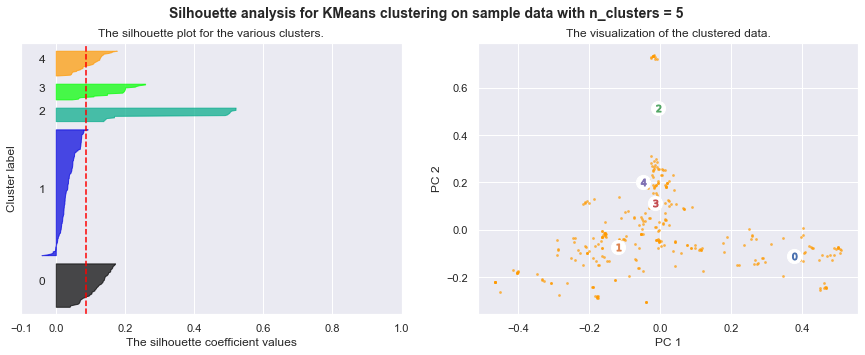

For n_clusters = 5, The average silhouette_score is : 0.087


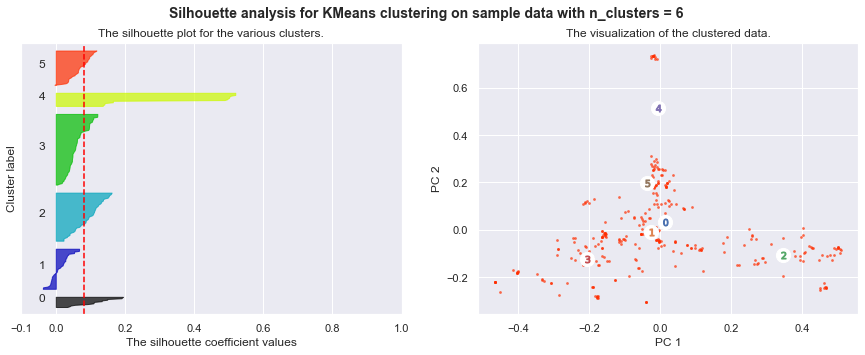

For n_clusters = 6, The average silhouette_score is : 0.081


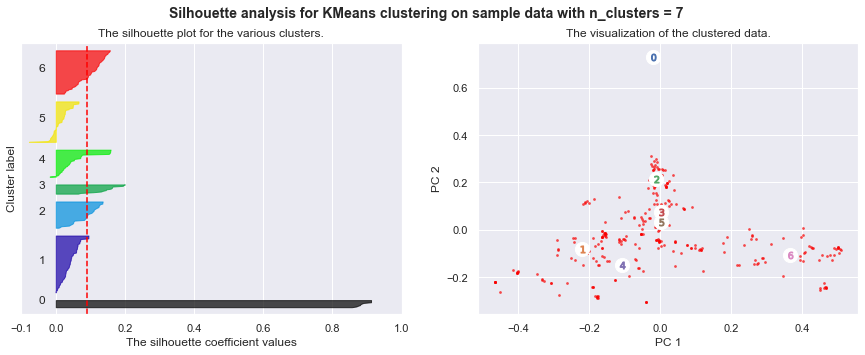

For n_clusters = 7, The average silhouette_score is : 0.091


In [63]:
ytbTFVectorizer, ytbTFVects = getTFVects(youtube)
for n in cluster_num:
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(ytbTFVects.toarray())
    reduced_data = pca.transform(ytbTFVects.toarray())
    X = ytbTFVects.toarray()
    plotSilhouette_revised(n, X, reduced_data)

#### Flat Clustering with $K$-means

In [64]:
colordict = {0: 'plum', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'blue', 5: 'red', 6: 'purple'}
def kMeanClustering(df, n):
    TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.50, max_features=1000, 
                                                           min_df=3, stop_words='english', norm='l2')
    TFVects = TFVectorizer.fit_transform(df['text'])
    km = sklearn.cluster.KMeans(n_clusters=n, init='k-means++')
    km.fit(TFVects.toarray())
    
    print("Evaluations")
    print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(df['text'], km.labels_)))
    print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(df['text'], km.labels_)))
    print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(df['text'], km.labels_)))
    print("Adjusted Rand Score: {:0.3f}\n".format(sklearn.metrics.adjusted_rand_score(df['text'], km.labels_)))
    
    # Distinguish features of the clusters
    print("Top terms per cluster:")
    terms = TFVectorizer.get_feature_names()
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    for i in range(n):
        print("Cluster %d:" % i)
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
        print('\n')
    
    df['kmeans_predictions'] = km.labels_
    colors = [colordict[c] for c in df['kmeans_predictions']]
    
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(TFVects.toarray())
    reduced_data = pca.transform(TFVects.toarray())
    components = pca.components_
    keyword_ids = list(set(order_centroids[:,:5].flatten()))
    words = [terms[i] for i in keyword_ids]
    x = components[:,keyword_ids][0,:]
    y = components[:,keyword_ids][1,:]
    
    fig = plt.figure(figsize = (16, 9))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
    for i, word in enumerate(words):
        ax.annotate(word, (x[i],y[i]))   
    plt.xticks(())
    plt.yticks(())
    plt.title('True Classes')
    plt.show()
    return df

Evaluations
Homogeneity: 0.220
Completeness: 1.000
V-measure: 0.360
Adjusted Rand Score: 0.004

Top terms per cluster:
Cluster 0:
 id
 new
 pumas
 just
 pair
 shoe
 today
 got
 like
 know


Cluster 1:
 help
 identify
 need
 shoes
 shoe
 id
 identifying
 pls
 puma
 pair


Cluster 2:
 collection
 puma
 rate
 new
 addition
 added
 latest
 wheel
 hoops
 meek


Cluster 3:
 rs
 clyde
 suede
 puma
 png
 court
 new
 classic
 colorway
 https


Cluster 4:
 shoes
 know
 does
 puma
 model
 buy
 love
 new
 wearing
 sneakers


Cluster 5:
 puma
 new
 code
 sneakers
 40
 com
 store
 sale
 adidas
 online




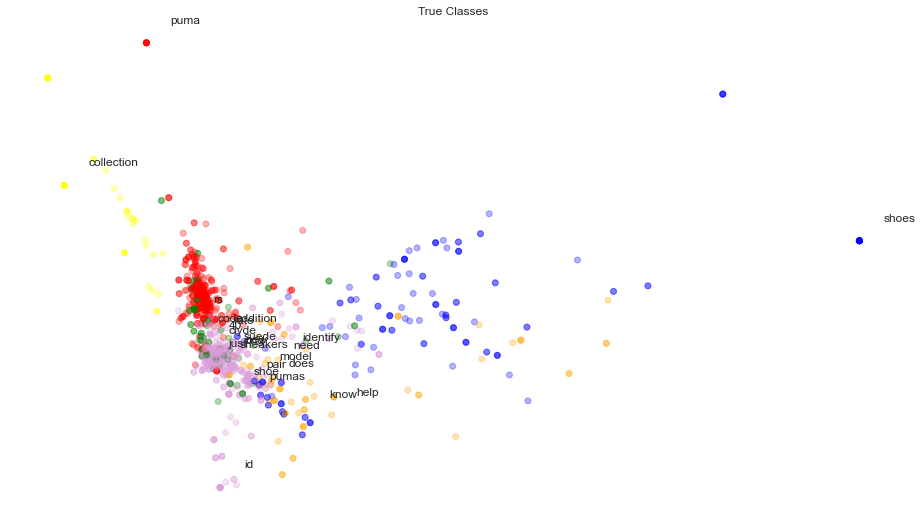

In [65]:
reddit = kMeanClustering(reddit, 6)

Evaluations
Homogeneity: 0.143
Completeness: 1.000
V-measure: 0.249
Adjusted Rand Score: 0.003

Top terms per cluster:
Cluster 0:
 pumafootball
 like
 new
 just
 don
 adidas
 kits
 bds
 think
 people


Cluster 1:
 cougarcoin
 cougarintothemoon
 cougaringlobal
 betterthandoge
 savecougars
 cougartr
 cougar
 ilonmask
 trustwalletapp
 rt


Cluster 2:
 rt
 goal
 amp
 new
 today
 just
 like
 chelsea
 win
 league


Cluster 3:
 poshmarkapp
 poshmark
 loving
 share
 fashion
 items
 check
 good
 shopmycloset
 style


Cluster 4:
 iheartawards
 vote
 louies
 bestfanarmy
 ltlatins
 bts_twt
 adoreyou
 bestlyrics
 iprotect94
 bestmusicvideo


Cluster 5:
 best
 rt
 team
 golf
 nice
 kit
 season
 shoe
 years
 did




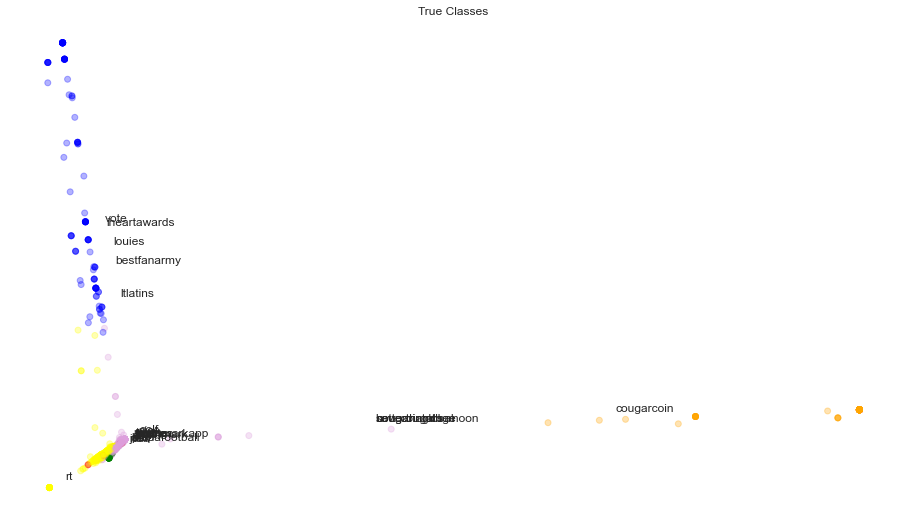

In [66]:
twitter = kMeanClustering(twitter, 6)

Evaluations
Homogeneity: 0.182
Completeness: 1.000
V-measure: 0.308
Adjusted Rand Score: 0.004

Top terms per cluster:
Cluster 0:
 nike
 adidas
 instagood
 love
 fashion
 model
 new
 instagram
 follow
 day


Cluster 1:
 crystaldesign
 dimensions
 cond
 issues
 tag
 divination
 basis
 reservation
 php
 fee


Cluster 2:
 nike
 sneakers
 adidas
 jordan
 shoes
 yeezy
 fashion
 style
 available
 sneakerhead


Cluster 3:
 football
 soccer
 pumafootball
 neymar
 follow
 mancity
 premierleague
 fifa
 psg
 nike


Cluster 4:
 yeezy_jordan_wp
 gafas
 yeezy500
 cinturón
 yeezy700
 15060620481
 86
 yeezy350
 whatsapp
 timberland


Cluster 5:
 salomon
 gucci
 huarache
 watches
 zapatillas
 clothing
 force
 asics
 sneaker
 jordans




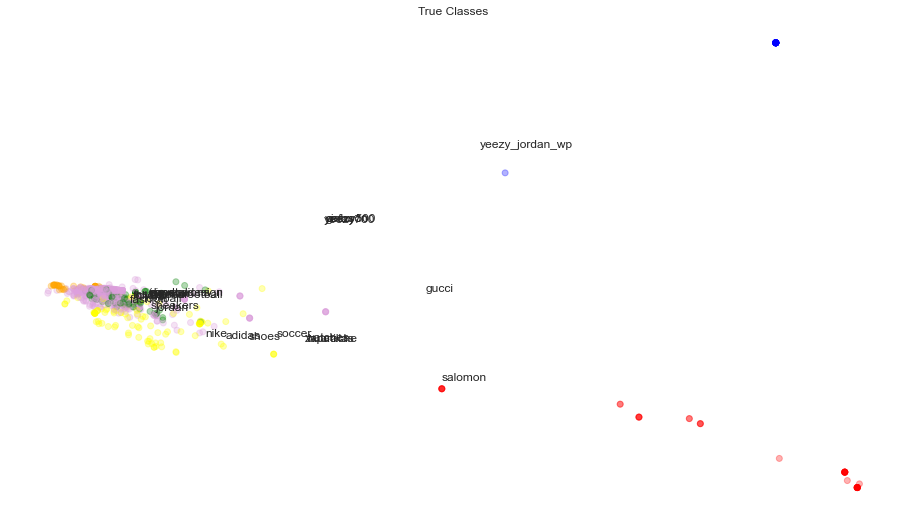

In [67]:
ins = kMeanClustering(ins, 6)

Evaluations
Homogeneity: 0.304
Completeness: 1.000
V-measure: 0.467
Adjusted Rand Score: 0.000

Top terms per cluster:
Cluster 0:
 casadora
 snow
 life
 ground
 rule
 moment
 la
 fromthe
 beautiful
 expect


Cluster 1:
 know
 just
 don
 really
 good
 want
 got
 right
 think
 yeah


Cluster 2:
 ve
 just
 really
 pumas
 suit
 logo
 got
 brand
 kind
 nike


Cluster 3:
 kill
 wildebeest
 bite
 male
 horns
 adult
 blue
 body
 prey
 video


Cluster 4:
 shoes
 shoe
 make
 running
 sure
 mario
 got
 just
 great
 super


Cluster 5:
 shoe
 foam
 soft
 cushioning
 lining
 features
 lace
 design
 got
 leather


Cluster 6:
 applause
 okay
 huh
 st
 ityou
 ah
 ford
 pumas
 hey
 crazy




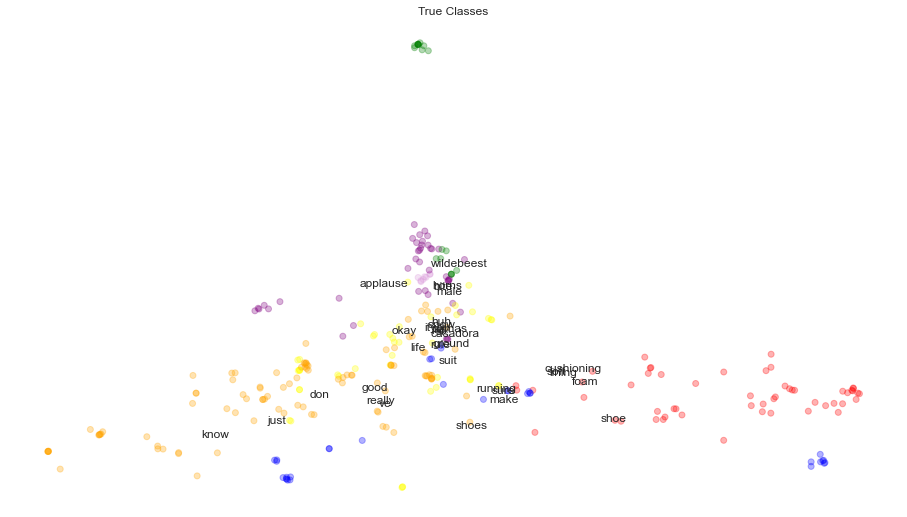

In [68]:
youtube = kMeanClustering(youtube, 7)

#### Hierarchical Cluster

In [69]:
def getLinkageMatrix(TFVects):
    CoocMat = TFVects * TFVects.T
    CoocMat.setdiag(0)
    matrix = scipy.cluster.hierarchy.ward(CoocMat[:50, :50].toarray())
    return matrix

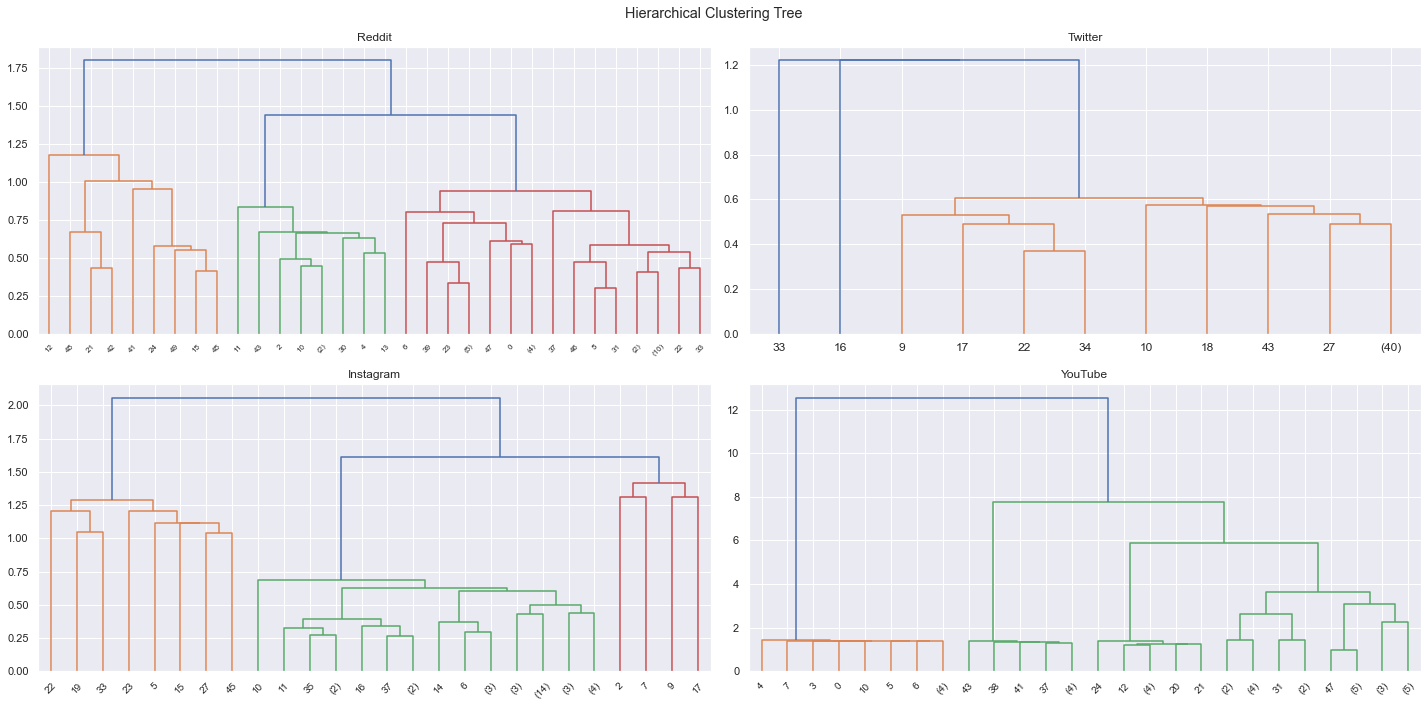

In [70]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle("Hierarchical Clustering Tree")

rdt_matrix = getLinkageMatrix(rdtTFVects)
scipy.cluster.hierarchy.dendrogram(rdt_matrix, p=6, truncate_mode='level', get_leaves=True, ax=axs[0, 0])
axs[0, 0].set_title("Reddit")
twt_matrix = getLinkageMatrix(twtTFVects)
scipy.cluster.hierarchy.dendrogram(twt_matrix, p=6, truncate_mode='level', get_leaves=True, ax=axs[0, 1])
axs[0, 1].set_title("Twitter")

ins_matrix = getLinkageMatrix(insTFVects)
scipy.cluster.hierarchy.dendrogram(ins_matrix, p=6, truncate_mode='level', get_leaves=True, ax=axs[1, 0])
axs[1, 0].set_title("Instagram")
ytb_matrix = getLinkageMatrix(ytbTFVects)
scipy.cluster.hierarchy.dendrogram(ytb_matrix, p=5, truncate_mode='level', get_leaves=True, ax=axs[1, 1])
axs[1, 1].set_title("YouTube")

fig.tight_layout()
plt.show()

In [71]:
def calculateWaldClustering(TFVects, title, n, df):
    CoocMat = TFVects * TFVects.T
    linkage_matrix_full = scipy.cluster.hierarchy.ward(CoocMat.toarray())
    hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, n, 'maxclust')
    print("Silhouetter score for " + title + " is " + 
          str(sklearn.metrics.silhouette_score(CoocMat, hierarchicalClusters_full)))
    df['wald_predictions'] = hierarchicalClusters_full
    return df

In [72]:
reddit = calculateWaldClustering(rdtTFVects, "Reddit", 6, reddit)
twitter = calculateWaldClustering(twtTFVects, "Twitter", 6, twitter)
ins = calculateWaldClustering(insTFVects, "Instagram", 6, ins)
youtube = calculateWaldClustering(ytbTFVects, "YouTube", 6, youtube)

Silhouetter score for Reddit is 0.13604044581528743
Silhouetter score for Twitter is 0.4480587665276091
Silhouetter score for Instagram is 0.1867270288000483
Silhouetter score for YouTube is 0.18095904598274454


#### Genism

In [73]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

reddit['reduced_tokens'] = reddit['normalized_tokens'].apply(lambda x: dropMissing(x, rdtTFVectorizer.vocabulary_.keys()))
twitter['reduced_tokens'] = twitter['normalized_tokens'].apply(lambda x: dropMissing(x, twtTFVectorizer.vocabulary_.keys()))
ins['reduced_tokens'] = ins['normalized_tokens'].apply(lambda x: dropMissing(x, insTFVectorizer.vocabulary_.keys()))
youtube['reduced_tokens'] = youtube['normalized_tokens'].apply(lambda x: dropMissing(x, ytbTFVectorizer.vocabulary_.keys()))

In [74]:
def conductLDAModel(df, title):
    dictionary = gensim.corpora.Dictionary(df['reduced_tokens'])
    corpus = [dictionary.doc2bow(text) for text in df['reduced_tokens']]
    gensim.corpora.MmCorpus.serialize(title, corpus)
    mmcorpus = gensim.corpora.MmCorpus(title)
    lda = gensim.models.ldamodel.LdaModel(corpus=mmcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')
    return dictionary, lda

In [75]:
rdt_dict, rdt_lda = conductLDAModel(reddit, "Reddit")
twt_dict, twt_lda = conductLDAModel(twitter, "Twitter")
ins_dict, ins_lda = conductLDAModel(ins, "Instagram")
ytb_dict, ytb_lda = conductLDAModel(youtube, "YouTube")

#### Reddit

In [76]:
rdt_ldaDF = pd.DataFrame({'upvotes' : reddit['upvotes'], 
                         'topics' : [rdt_lda[rdt_dict.doc2bow(l)] for l in reddit['reduced_tokens']]})
topicsProbDict = {i : [0] * len(rdt_ldaDF) for i in range(rdt_lda.num_topics)}

for index, topicTuples in enumerate(rdt_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(rdt_lda.num_topics):
    rdt_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

rdt_ldaDF.head()

,upvotes,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,3,"[(0, 0.8985181), (1, 0.011021475), (2, 0.01080...",0.898518,0.011021,0.010803,0.012001,0.010941,0.011561,0.011167,0.011524,0.010959,0.011505
1,15,"[(0, 0.013528296), (1, 0.012619646), (2, 0.012...",0.013528,0.012620,0.012369,0.013740,0.012527,0.013237,0.012785,0.013195,0.012549,0.883450
2,2,"[(6, 0.5879019), (7, 0.3566219)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.587902,0.356622,0.000000,0.000000
3,2,"[(0, 0.87922525), (3, 0.0852663)]",0.879225,0.000000,0.000000,0.085266,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,3,"[(0, 0.02395112), (1, 0.7926689), (2, 0.021897...",0.023951,0.792669,0.021897,0.024328,0.022179,0.023442,0.022636,0.023360,0.022215,0.023322


In [77]:
rdt_ldaDF.sort_values(by=['upvotes'], ascending=False, inplace=True)
rdt_ldaDFV = rdt_ldaDF[:10][['topic_%d' %x for x in range(10)]]
rdt_ldaDFVisN = rdt_ldaDF[:10][['upvotes']]
rdt_ldaDFVis = rdt_ldaDFV.values
rdt_ldaDFVisNames = rdt_ldaDFVisN.values

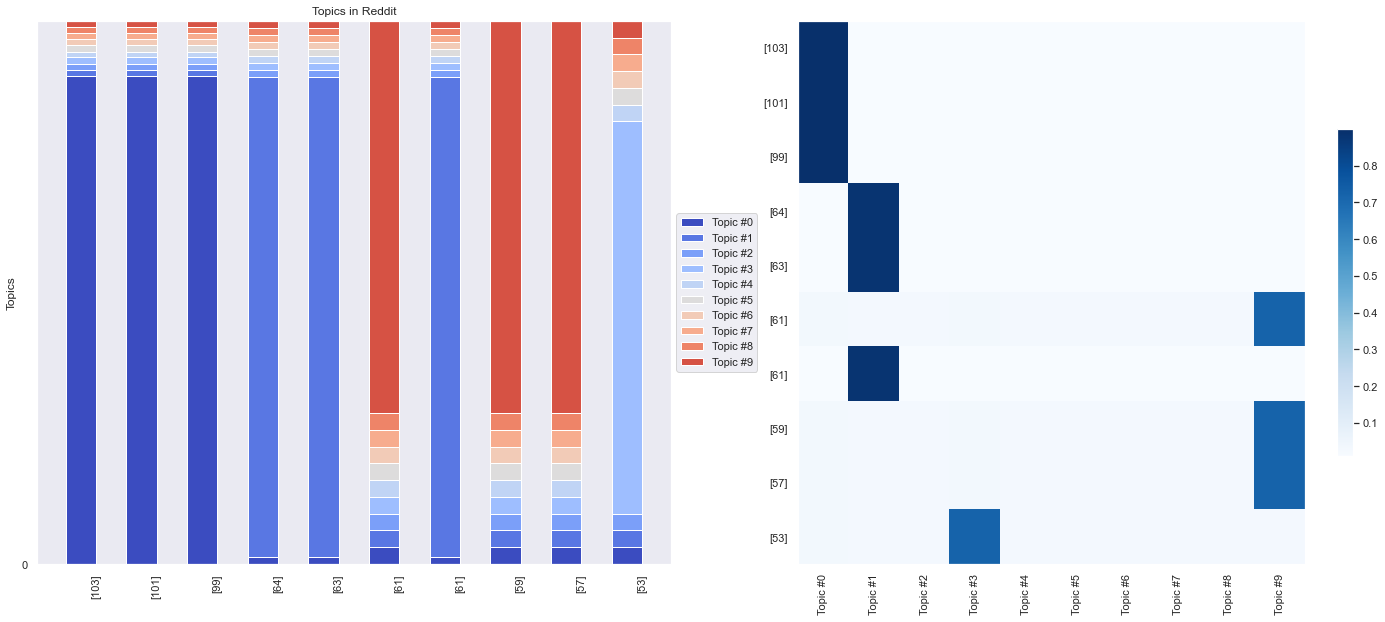

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = rdt_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, rdt_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, rdt_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += rdt_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Reddit")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(rdt_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(rdt_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(rdt_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(rdt_ldaDFVisNames);
ax2.set_xticks(np.arange(rdt_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(rdt_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

In [79]:
topicsDict = {}
for topicNum in range(rdt_lda.num_topics):
    topicWords = [w for w, p in rdt_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,puma,puma,puma,puma,puma,puma,puma,puma,puma,puma
1,new,store,help,size,pair,shoe,new,love,suede,pumas
2,shoe,ve,buy,pair,help,collection,help,size,new,help
3,look,rs,guys,like,rs,new,pair,pumas,pumas,model
4,sneakers,code,like,shoe,need,future,came,new,black,new
5,refund,online,code,ve,new,help,style,wearing,help,cat
6,like,today,today,clyde,got,like,like,design,green,style
7,black,help,worn,buy,size,gold,black,years,finally,got
8,got,saw,family,fit,white,got,looking,white,today,identify
9,clyde,day,laces,new,pumas,model,look,model,identify,pair


In [80]:
rdt_ldaDFV = rdt_ldaDF[-10:][['topic_%d' %x for x in range(10)]]
rdt_ldaDFVisN = rdt_ldaDF[-10:][['upvotes']]
rdt_ldaDFVis = rdt_ldaDFV.values
rdt_ldaDFVisNames = rdt_ldaDFVisN.values

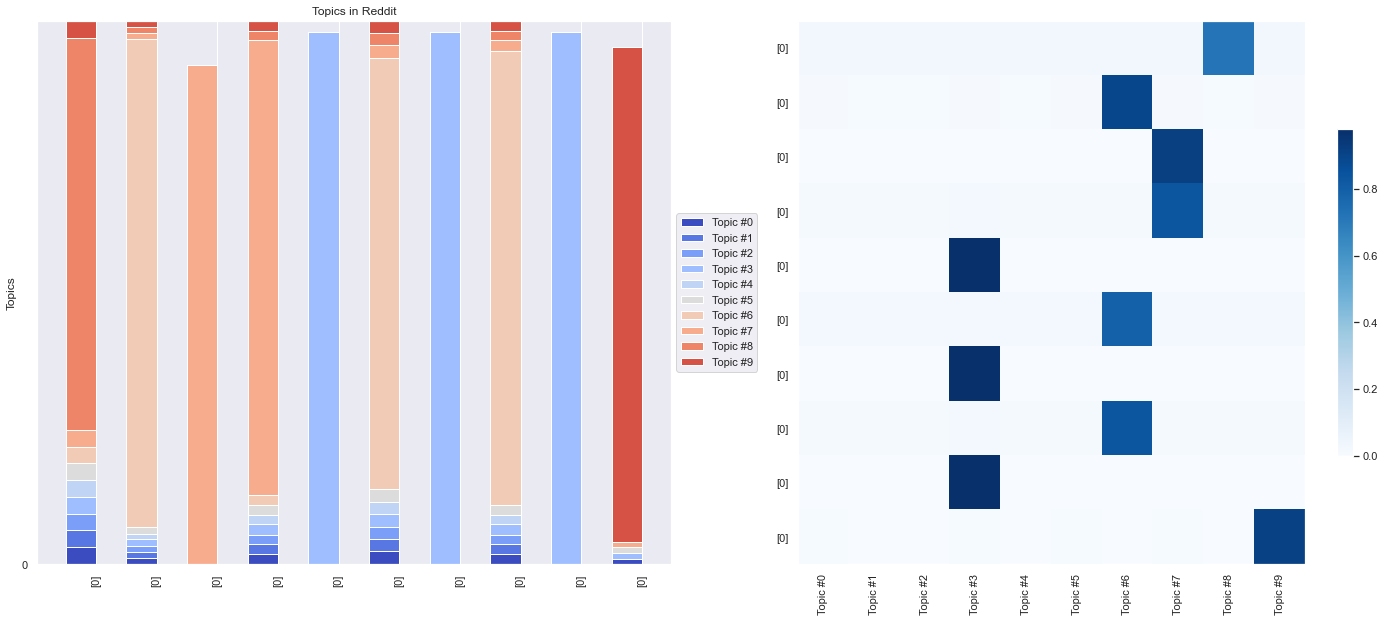

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = rdt_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, rdt_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, rdt_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += rdt_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Reddit")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(rdt_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(rdt_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(rdt_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(rdt_ldaDFVisNames);
ax2.set_xticks(np.arange(rdt_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(rdt_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

#### Twitter

In [82]:
twt_ldaDF = pd.DataFrame({'favorite_cnt' : twitter['favorite_cnt'],
                         'topics' : [twt_lda[twt_dict.doc2bow(l)] for l in twitter['reduced_tokens']]})
topicsProbDict = {i : [0] * len(twt_ldaDF) for i in range(twt_lda.num_topics)}

for index, topicTuples in enumerate(twt_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(twt_lda.num_topics):
    twt_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

twt_ldaDF.head()

,favorite_cnt,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0,"[(0, 0.021899901), (1, 0.023391295), (2, 0.023...",0.021900,0.023391,0.023869,0.022640,0.023914,0.022994,0.021908,0.792697,0.024271,0.022416
1,2,"[(0, 0.862402), (1, 0.015448472), (2, 0.015762...",0.862402,0.015448,0.015763,0.014952,0.015789,0.015185,0.014468,0.015162,0.016028,0.014803
2,0,"[(0, 0.01741834), (1, 0.018605169), (2, 0.0189...",0.017418,0.018605,0.018984,0.018015,0.019015,0.018288,0.017425,0.018262,0.019304,0.834683
3,1,"[(0, 0.02943966), (1, 0.03144382), (2, 0.03208...",0.029440,0.031444,0.032085,0.030434,0.032136,0.030909,0.029453,0.376107,0.377862,0.030131
4,0,"[(0, 0.014464309), (1, 0.015450034), (2, 0.015...",0.014464,0.015450,0.015765,0.014953,0.015793,0.015187,0.014470,0.015164,0.016031,0.862723


In [83]:
twt_ldaDF.sort_values(by=['favorite_cnt'], ascending=False, inplace=True)
twt_ldaDFV = twt_ldaDF[:10][['topic_%d' %x for x in range(10)]]
twt_ldaDFVisN = twt_ldaDF[:10][['favorite_cnt']]
twt_ldaDFVis = twt_ldaDFV.values
twt_ldaDFVisNames = twt_ldaDFVisN.values

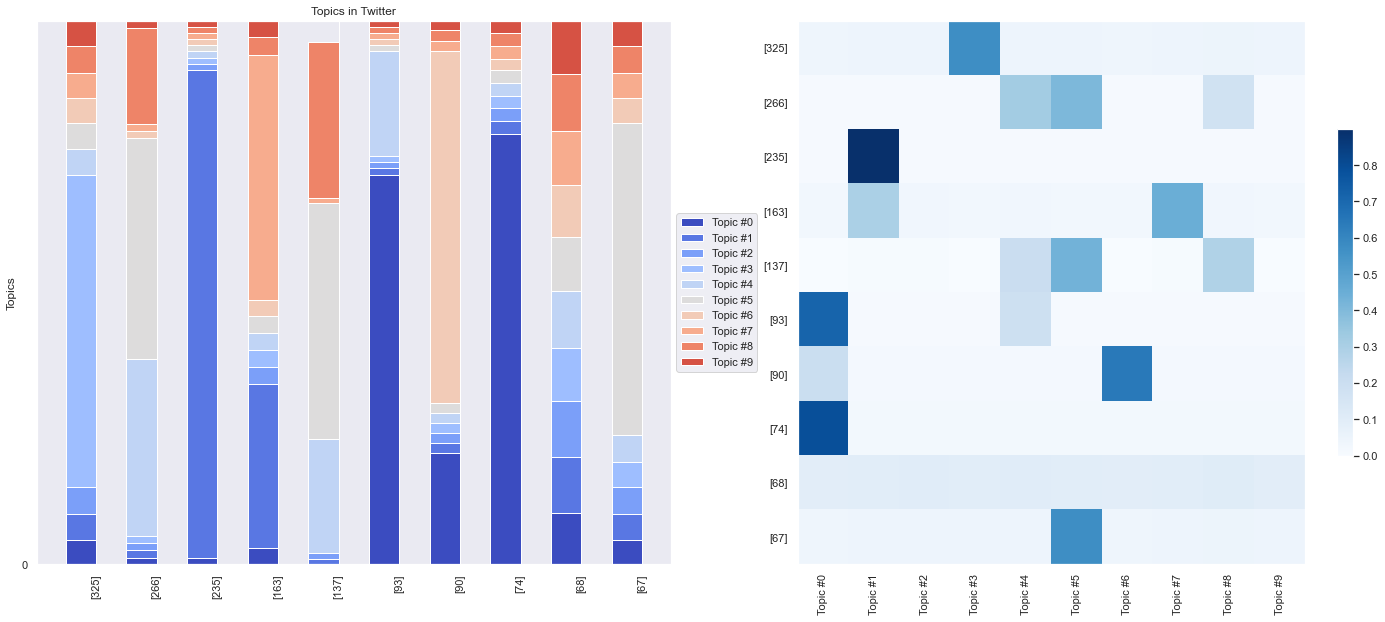

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = twt_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, twt_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, twt_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += twt_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Twitter")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(twt_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(twt_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(twt_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(twt_ldaDFVisNames);
ax2.set_xticks(np.arange(twt_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(twt_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

In [85]:
topicsDict = {}
for topicNum in range(twt_lda.num_topics):
    topicWords = [w for w, p in twt_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,shoe,saying,rs,think,poshmark,forget,iheartawards,iheartawards,cop,voting
1,price,better,like,signs,check,betterthandoge,vote,vote,instore,na
2,suede,boycott,dreamers,best,like,cougaringlobal,guy,christian,online,panther
3,comfortable,check,season,new,rider,savecougars,bestmusicvideo,bestfanarmy,mayze,people
4,sky,pair,black,long,nah,cougarintothemoon,palestinians,btsarmy,cat,bds
5,sizes,adidas,summer,love,good,cougarcoin,sponsored,looking,mountain,wish
6,signature,year,special,player,added,thanks,onlyseeapartheid,boycott,court,hi
7,kit,got,feel,wnba,let,new,onlyseegreat,bestlyrics,available,movement
8,stewart,football,chelsea,st,marseille,cougar,need,adoreyou,new,set
9,like,yeonjun,team,nike,mr,fully,pair,israel,look,need


In [86]:
twt_ldaDFV = twt_ldaDF[-10:][['topic_%d' %x for x in range(10)]]
twt_ldaDFVisN = twt_ldaDF[-10:][['favorite_cnt']]
twt_ldaDFVis = twt_ldaDFV.values
twt_ldaDFVisNames = twt_ldaDFVisN.values

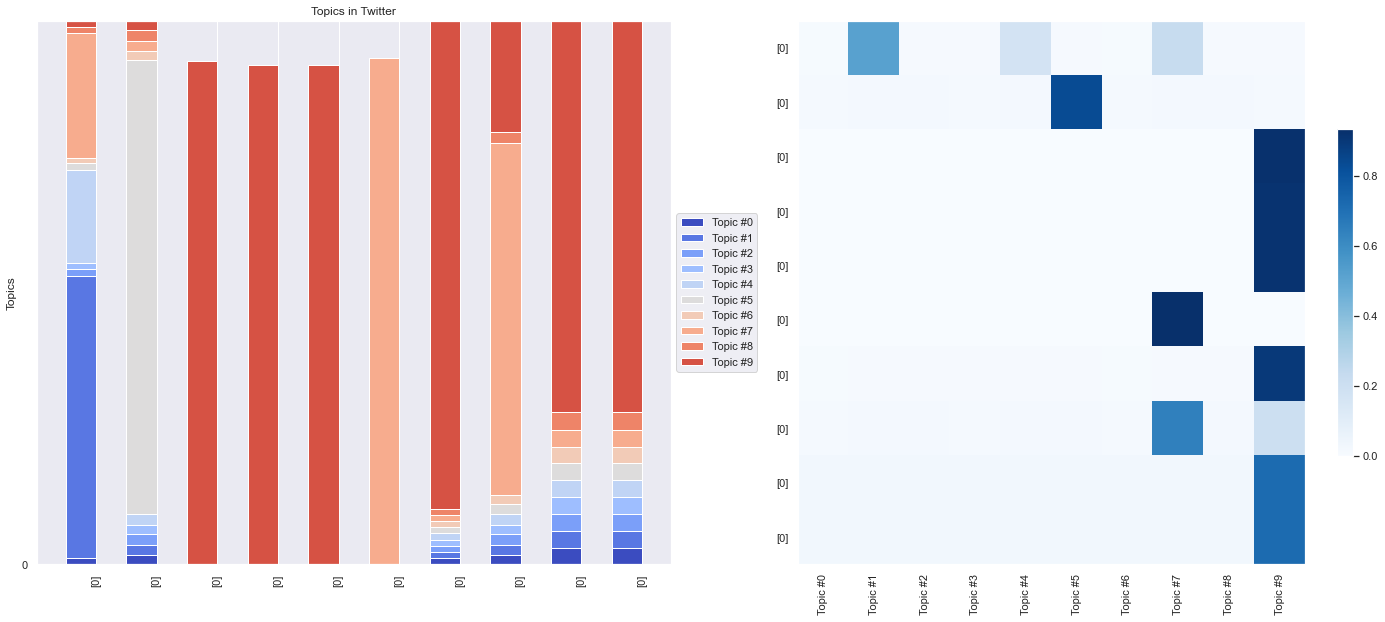

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = twt_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, twt_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, twt_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += twt_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Twitter")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(twt_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(twt_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(twt_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(twt_ldaDFVisNames);
ax2.set_xticks(np.arange(twt_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(twt_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

#### Instagram

In [88]:
ins_ldaDF = pd.DataFrame({'likes' : ins['likes'],
                         'topics' : [ins_lda[ins_dict.doc2bow(l)] for l in ins['reduced_tokens']]})
topicsProbDict = {i : [0] * len(ins_ldaDF) for i in range(ins_lda.num_topics)}

for index, topicTuples in enumerate(ins_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(ins_lda.num_topics):
    ins_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ins_ldaDF.head()

,likes,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,2508,"[(0, 0.092147976), (1, 0.10407363), (2, 0.0988...",0.092148,0.104074,0.098850,0.100613,0.093985,0.103195,0.098539,0.096901,0.098894,0.112802
1,146,"[(4, 0.27564505), (5, 0.67812574)]",0.000000,0.000000,0.000000,0.000000,0.275645,0.678126,0.000000,0.000000,0.000000,0.000000
2,144,"[(9, 0.95214)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.952140
14,38,"[(0, 0.010034581), (1, 0.01133387), (2, 0.2414...",0.010035,0.011334,0.241455,0.010956,0.010235,0.551696,0.010731,0.130504,0.010770,0.012284
15,63,"[(0, 0.010034578), (1, 0.011333885), (2, 0.010...",0.010035,0.011334,0.010764,0.010957,0.010235,0.011238,0.010731,0.010552,0.010769,0.903385


In [89]:
ins_ldaDF.dropna(subset=['likes'], inplace=True)
ins_ldaDF = ins_ldaDF[ins_ldaDF.likes.str.isnumeric()]
ins_ldaDF["likes"] = ins_ldaDF["likes"].astype(str).astype(int)

In [90]:
ins_ldaDF.sort_values(by=['likes'], ascending=False, inplace=True)
ins_ldaDFV = ins_ldaDF[:10][['topic_%d' %x for x in range(10)]]
ins_ldaDFVisN = ins_ldaDF[:10][['likes']]
ins_ldaDFVis = ins_ldaDFV.values
ins_ldaDFVisNames = ins_ldaDFVisN.values

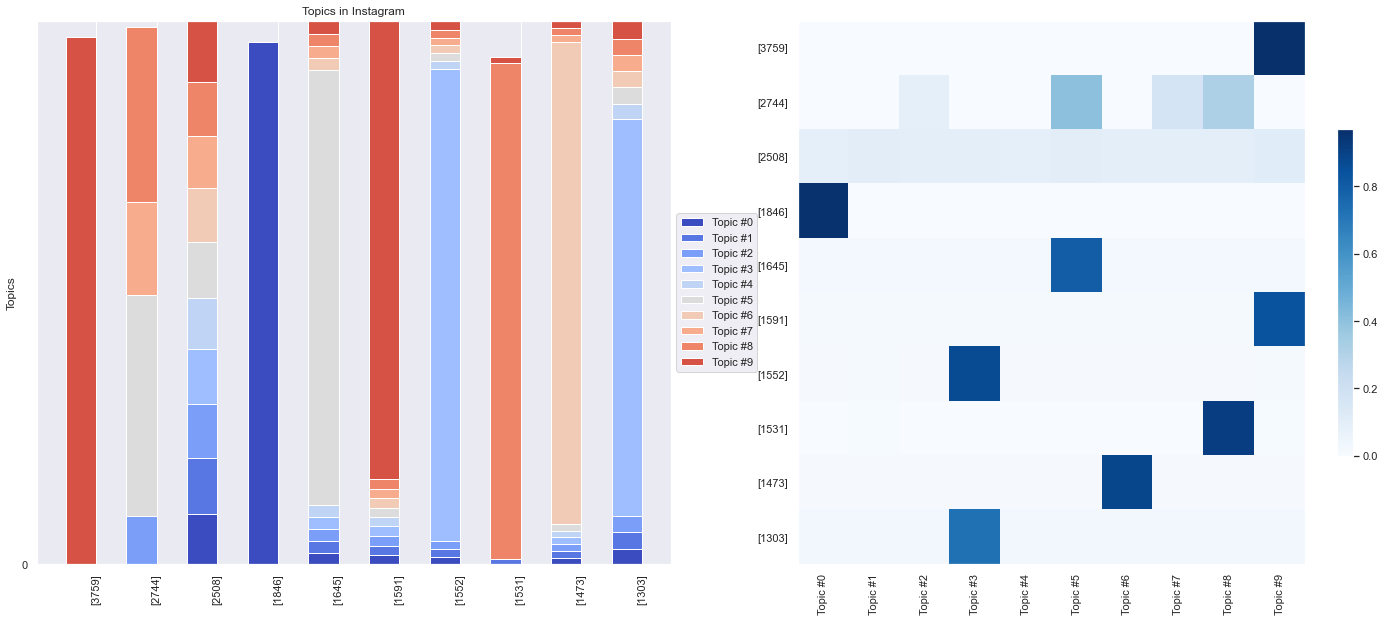

In [91]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = ins_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, ins_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, ins_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ins_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Instagram")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(ins_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(ins_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(ins_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(ins_ldaDFVisNames);
ax2.set_xticks(np.arange(ins_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(ins_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

In [92]:
topicsDict = {}
for topicNum in range(ins_lda.num_topics):
    topicWords = [w for w, p in ins_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,nike,nike,adidas,nike,nike,nike,adidas,nike,nike,nike
1,adidas,adidas,new,adidas,adidas,adidas,order,adidas,new,adidas
2,vintage,sneakers,football,jordan,follow,follow,nike,available,available,fashion
3,fashion,instagood,nike,sneakers,model,football,shipping,free,adidas,jordan
4,shop,fitness,soccer,available,gucci,price,size,price,gucci,whatsapp
5,yeezy,original,follow,love,style,available,add,gucci,timberland,sneakers
6,football,leather,training,follow,like4likes,instagram,basis,instagood,whatsapp,timberland
7,love,love,run,nikeshoes,instagood,likeforlikes,comment,style,jersey,free
8,retro,follow,available,instagram,gainwithbundi,soccer,dimensions,sneaker,gafas,follow
9,instafashion,india,futbol,nikeairmax,gainwithspikes,black,issues,sneakers,dm,jersey


In [93]:
ins_ldaDFV = ins_ldaDF[-10:][['topic_%d' %x for x in range(10)]]
ins_ldaDFVisN = ins_ldaDF[-10:][['likes']]
ins_ldaDFVis = ins_ldaDFV.values
ins_ldaDFVisNames = ins_ldaDFVisN.values

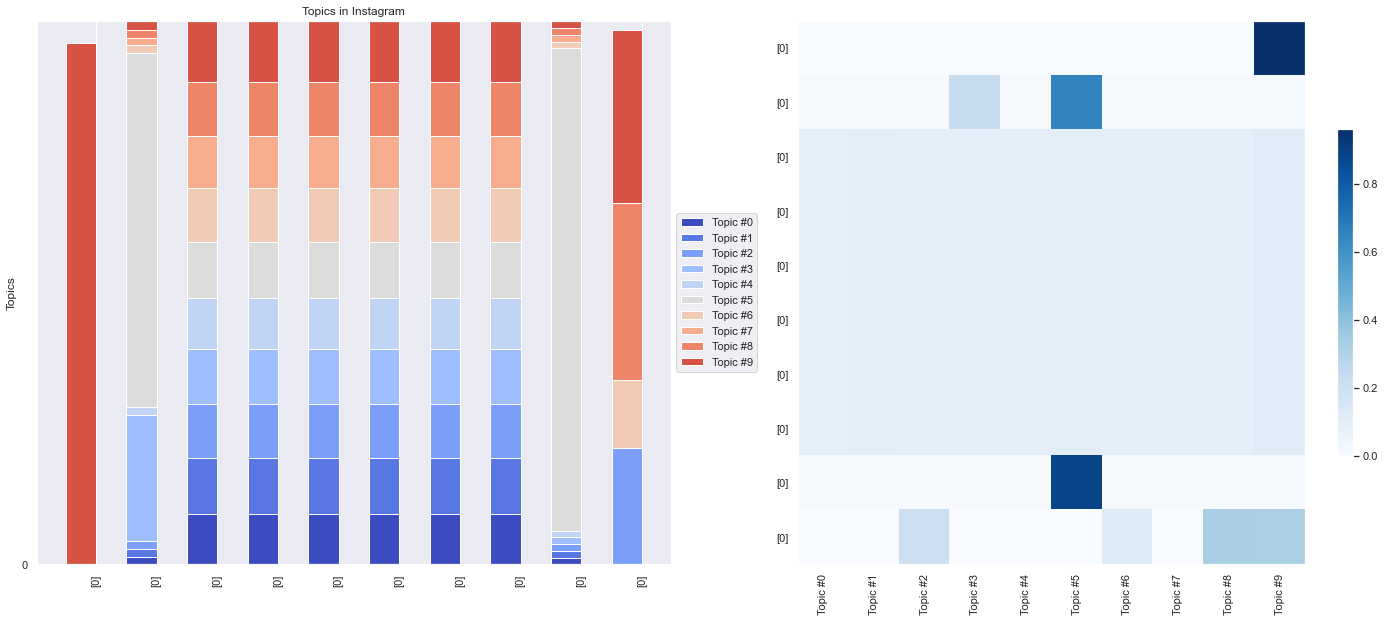

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = ins_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, ins_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, ins_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ins_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Instagram")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(ins_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(ins_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(ins_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(ins_ldaDFVisNames);
ax2.set_xticks(np.arange(ins_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(ins_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

#### YouTube

In [95]:
ytb_ldaDF = pd.DataFrame({'likeCount' : youtube['likeCount'],
                         'topics' : [ytb_lda[ytb_dict.doc2bow(l)] for l in youtube['reduced_tokens']]})
topicsProbDict = {i : [0] * len(ytb_ldaDF) for i in range(ytb_lda.num_topics)}

for index, topicTuples in enumerate(ytb_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(ytb_lda.num_topics):
    ytb_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ytb_ldaDF.head()

,likeCount,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
26,2339,"[(8, 0.9914995)]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.991499,0.0
28,803,"[(8, 0.9914691)]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.991469,0.0
29,4150,"[(8, 0.99157244)]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.991572,0.0
30,24665,"[(8, 0.9912745)]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.991274,0.0
31,715,"[(8, 0.9912745)]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.991274,0.0


In [96]:
ytb_ldaDF = ytb_ldaDF[ytb_ldaDF.likeCount.str.isnumeric()]
ytb_ldaDF["likeCount"] = ytb_ldaDF["likeCount"].astype(str).astype(int)

In [97]:
ytb_ldaDF.sort_values(by=['likeCount'], ascending=False, inplace=True)
ytb_ldaDFV = ytb_ldaDF[:10][['topic_%d' %x for x in range(10)]]
ytb_ldaDFVisN = ytb_ldaDF[:10][['likeCount']]
ytb_ldaDFVis = ytb_ldaDFV.values
ytb_ldaDFVisNames = ytb_ldaDFVisN.values

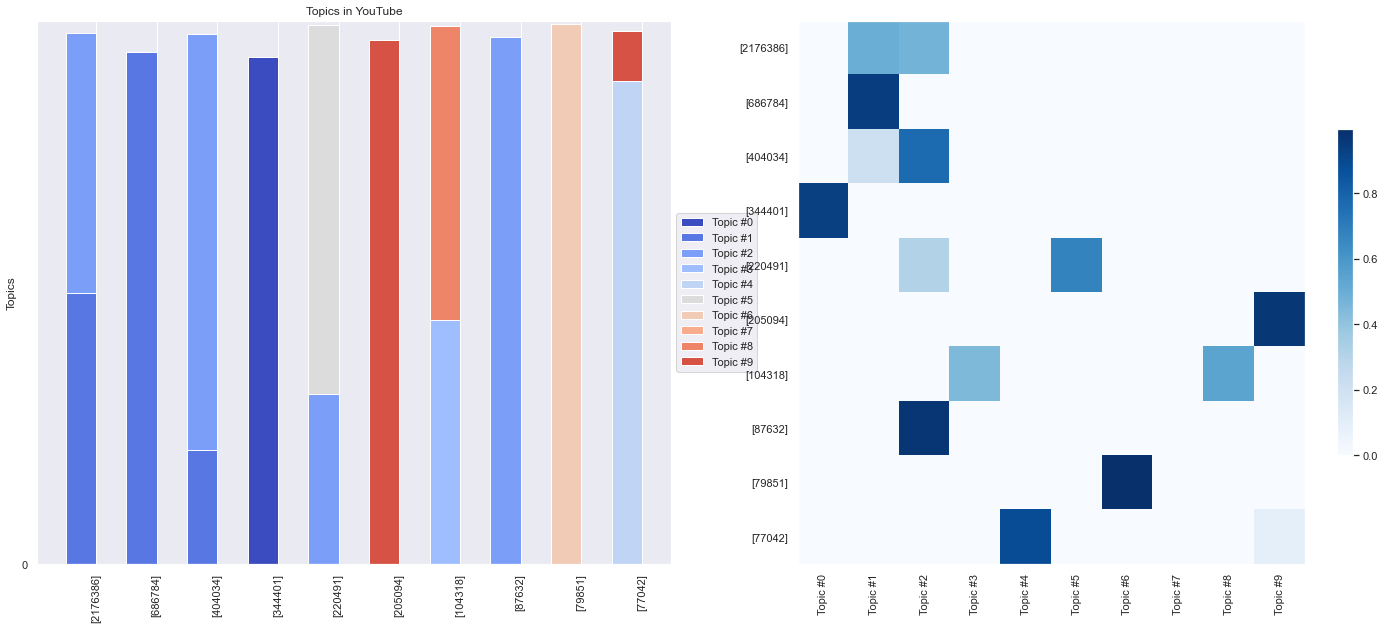

In [98]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = ytb_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, ytb_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, ytb_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ytb_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "YouTube")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(ytb_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(ytb_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(ytb_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(ytb_ldaDFVisNames);
ax2.set_xticks(np.arange(ytb_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(ytb_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

In [99]:
topicsDict = {}
for topicNum in range(ytb_lda.num_topics):
    topicWords = [w for w, p in ytb_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,going,ve,ve,going,right,kind,going,going,right,right
1,want,going,yeah,want,time,ve,want,right,good,want
2,time,want,think,time,new,look,right,want,going,new
3,think,right,want,ve,ve,car,good,little,think,going
4,right,time,good,right,kind,good,guy,good,time,actually
5,ve,kind,come,little,come,shoe,time,yeah,lot,time
6,let,good,kind,day,going,think,think,shoe,want,let
7,guys,think,oh,lot,want,right,big,ve,guys,think
8,come,lot,right,way,think,want,look,let,let,great
9,man,oh,mr,need,good,let,come,time,new,good


In [100]:
ytb_ldaDFV = ytb_ldaDF[-10:][['topic_%d' %x for x in range(10)]]
ytb_ldaDFVisN = ytb_ldaDF[-10:][['likeCount']]
ytb_ldaDFVis = ytb_ldaDFV.values
ytb_ldaDFVisNames = ytb_ldaDFVisN.values

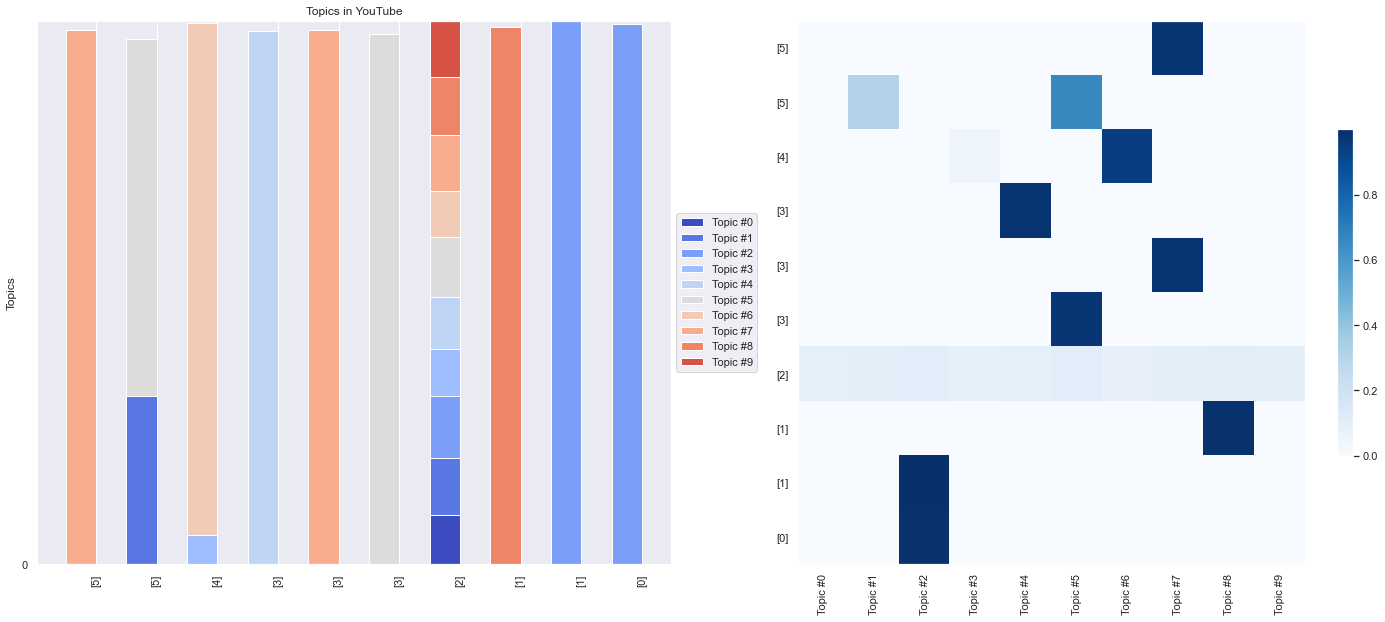

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = ytb_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, ytb_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, ytb_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ytb_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "YouTube")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(ytb_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(ytb_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(ytb_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(ytb_ldaDFVisNames);
ax2.set_xticks(np.arange(ytb_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(ytb_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

#### NLTK Topic Modeling

In [102]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

def get_lemmas(text):
    stop = nltk.corpus.stopwords.words('english') + list(string.punctuation)
    tokens = [i for i in nltk.word_tokenize(text.lower()) if i not in stop]
    lemmas = [nltk.stem.WordNetLemmatizer().lemmatize(t, get_wordnet_pos(t)) for t in tokens]
    return lemmas

def make_bigrams(lemmas, min_count=5):
    bigram = models.Phrases(lemmas, min_count)
    bigram_mod = models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in lemmas]

def make_bag_words(lemmas):
    dictionary = corpora.Dictionary([i for i in lemmas])
    bow_corpus = [dictionary.doc2bow(text) for text in lemmas]
    return dictionary, bow_corpus

In [103]:
def nltkTopicModeling(df_list, title_list, num_topics=3, num_words=20):
    for i in range(len(df_list)):
        print("Topic Modeling for " + title_list[i])
        text = df_list[i].text.apply(get_lemmas)
        dic, bow = make_bag_words(make_bigrams(text))
        model = models.ldamodel.LdaModel(bow, num_topics=num_topics, id2word=dic, passes=20, iterations=400)
        print(model.print_topics(num_words=num_words))
        print("\n")

In [104]:
nltkTopicModeling(df_lst, title_lst)

Topic Modeling for Reddit
[(0, '0.033*"puma" + 0.029*"shoe" + 0.018*"’" + 0.015*"get" + 0.015*"pair" + 0.014*"find" + 0.014*"anyone_know" + 0.009*"http" + 0.007*"name" + 0.007*"n\'t" + 0.007*"buy" + 0.006*"new" + 0.006*"size" + 0.006*"..." + 0.005*"\'s" + 0.005*"help" + 0.005*"year" + 0.005*"love" + 0.005*"call" + 0.005*"know"'), (1, '0.032*"puma" + 0.009*"’" + 0.008*"\'s" + 0.008*"new" + 0.006*"like" + 0.006*"day" + 0.006*"..." + 0.006*"\'\'" + 0.006*"see" + 0.006*"refund" + 0.006*"look" + 0.005*"``" + 0.005*"anyone" + 0.004*"future_rider" + 0.004*"guy" + 0.004*"sneaker" + 0.004*"first" + 0.004*"clyde" + 0.004*"u" + 0.004*"available"'), (2, '0.060*"puma" + 0.021*"shoe" + 0.011*"’" + 0.011*"look" + 0.010*"new" + 0.010*"x" + 0.008*"get" + 0.007*"size" + 0.007*"anyone" + 0.006*"collection" + 0.006*"wear" + 0.006*"model" + 0.006*"pair" + 0.006*"\'s" + 0.006*"would" + 0.006*"code" + 0.005*"find" + 0.005*"one" + 0.005*"make" + 0.005*"know"')]


Topic Modeling for Twitter
[(0, '0.026*"rt" + 